# Optuna Tuning | RandomForestClassifier
**RandomForestClassifier** hyper-parameter tuning for the [UCI dataset](https://archive.ics.uci.edu/dataset/296/diabetes+130-us+hospitals+for+years+1999-2008). The dataset represents ten years (1999-2008) of clinical care at 130 US hospitals and integrated delivery networks.

> **[CAUTION]** Do <u>NOT</u> execute "Run All", that will tell Optuna to run hyper-parameter tuning, regardless of whether you have already done it or not. Avoid running the _"Hyper-parameter tuning"_ subsections if you don't have to.

## **0. Initial Setup**
Taking care of package imports, defining work constants, and loading all necessary datasets.

### 0.1 Python imports

In [226]:
# Data Analysis
import numpy as np
import pandas as pd

# Hyperparameter optimization
import optuna

# Machine learning
import os

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Visualization configurations
pd.set_option('display.max_columns', 60)
plt.style.use('ggplot')
sns.set_style('white')

In [227]:
from collections import Counter

from imblearn.combine import SMOTETomek
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler, TomekLinks

from optuna.storages import JournalStorage
from optuna.storages.journal import JournalFileBackend

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, fbeta_score, make_scorer, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler

### 0.2 Constants

In [228]:
DATA_PATH = '../data/original/'
DATA_PATH_PROCESSED = '../data/processed/'

MODEL_NAME = 'rf' # Modify this to the model you are using

OPTUNA_PATH = '../optuna/'
OPTUNA_DIR = OPTUNA_PATH + MODEL_NAME + '/'

STUDY_NAME = "Diabetes_130-US"
STUDY_PATH_NONE = OPTUNA_DIR + f"optuna_{MODEL_NAME}_none.log"
STUDY_PATH_RUS = OPTUNA_DIR + f"optuna_{MODEL_NAME}_rus.log"
STUDY_PATH_SMOTE = OPTUNA_DIR + f"optuna_{MODEL_NAME}_smote.log"
STUDY_PATH_SMOTE_TOMEK = OPTUNA_DIR + f"optuna_{MODEL_NAME}_smote-tomek.log"

# Ensure the directories exist
os.makedirs(OPTUNA_DIR, exist_ok=True)
os.makedirs(os.path.dirname(STUDY_PATH_NONE), exist_ok=True)

N_TRIALS = 100
RANDOM_STATE = 38

SCORE_NAME = 'F1-Score'
SCORING = make_scorer(fbeta_score, beta=1, average='macro')

### 0.3 Loading datasets

In [229]:
train_set = pd.read_csv(
    DATA_PATH_PROCESSED + 'train.csv',
    na_values='?',
    keep_default_na=False
)

test_set = pd.read_csv(
    DATA_PATH_PROCESSED + 'test.csv',
    na_values='?',
    keep_default_na=False
)

## **1. Feature Scaling**
Applying scaling to numerical features.

In [230]:
target = 'readmitted'

X_train = train_set.drop(target, axis=1)
y_train = train_set[target]

X_test = test_set.drop(target, axis=1)
y_test = test_set[target]

### 1.1 Scaling
Applying scaling to numerical features, while leaving boolean features untouched.

In [231]:
NUMERICAL_COLUMNS = [
    'age', 'time_in_hospital', 'num_medications',
    'num_emergency', 'num_inpatient', 'num_diagnoses'
]

In [232]:
scaler = StandardScaler()

X_train[NUMERICAL_COLUMNS] = scaler.fit_transform(X_train[NUMERICAL_COLUMNS])
X_test[NUMERICAL_COLUMNS] = scaler.transform(X_test[NUMERICAL_COLUMNS])

In [233]:
print('Train set:', Counter(y_train))
print('Test set:', Counter(y_test))

Train set: Counter({0: 45522, 1: 4523})
Test set: Counter({0: 19510, 1: 1938})


## **2. Optuna Hyper-parameter Tuning | No under/oversampling**
Hyper-parameter tuning of the model using Optuna, with no undersampling/oversampling.

### 2.1 Objective & study setup
Preparing the objective function with all hyper-parameters, and creating/loading the Optuna study.

In [234]:
def objective(trial: optuna.Trial) -> float:
    # Hyperparameter search space
    params = {
        "n_estimators": 100,
        "max_depth": trial.suggest_int("max_depth", 4, 30, step=2),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 2, 60, step=2)
    }
    
    # Define validation folds
    kf = StratifiedKFold(n_splits=5, shuffle=False)
    model = RandomForestClassifier(**params, random_state=RANDOM_STATE)
    
    # Cross validation
    scores = cross_val_score(model, X_train, y_train, cv=kf, scoring=SCORING)

    print("Cross validation scores: {}".format(scores))
    print("Average score: {}".format(scores.mean()))

    return scores.mean()

In [235]:
# Set up study with name and storage
storage = JournalStorage(JournalFileBackend(STUDY_PATH_NONE))

study = optuna.create_study(
    direction="maximize",
    study_name=STUDY_NAME,
    storage=storage,
    load_if_exists=True,
    sampler=optuna.samplers.TPESampler(constant_liar=True, seed=RANDOM_STATE),
    pruner=optuna.pruners.SuccessiveHalvingPruner()
)

optuna.logging.set_verbosity(optuna.logging.INFO)

/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/optuna/_experimental.py:31: ExperimentalWarning:

Argument ``constant_liar`` is an experimental feature. The interface can change in the future.

[I 2024-12-31 13:07:00,732] A new study created in Journal with name: Diabetes_130-US


### 2.2 Hyper-parameter tuning
**(CAUTION)** <u>Do not run</u>, unless you already need to find the best parameters. If you already have bound the best model configuration, <u>run the section above</u> _(Objective & study setup)_.

In [236]:
study.optimize(
    objective,
    n_trials=N_TRIALS,
    n_jobs=-1 # Use all available cores
)

[I 2024-12-31 13:07:12,373] Trial 3 finished with value: 0.47633597337075617 and parameters: {'max_depth': 20, 'min_samples_leaf': 60}. Best is trial 3 with value: 0.47633597337075617.
[I 2024-12-31 13:07:12,387] Trial 0 finished with value: 0.47633597337075617 and parameters: {'max_depth': 18, 'min_samples_leaf': 60}. Best is trial 0 with value: 0.47633597337075617.
[I 2024-12-31 13:07:12,414] Trial 1 finished with value: 0.47633597337075617 and parameters: {'max_depth': 22, 'min_samples_leaf': 58}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617
Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617
Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2024-12-31 13:07:12,819] Trial 6 finished with value: 0.47633597337075617 and parameters: {'max_depth': 12, 'min_samples_leaf': 26}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617
Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2024-12-31 13:07:13,018] Trial 8 finished with value: 0.47633597337075617 and parameters: {'max_depth': 24, 'min_samples_leaf': 42}. Best is trial 0 with value: 0.47633597337075617.
[I 2024-12-31 13:07:13,579] Trial 4 finished with value: 0.47633597337075617 and parameters: {'max_depth': 18, 'min_samples_leaf': 26}. Best is trial 0 with value: 0.47633597337075617.
[I 2024-12-31 13:07:13,754] Trial 5 finished with value: 0.47633597337075617 and parameters: {'max_depth': 14, 'min_samples_leaf': 14}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617
Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2024-12-31 13:07:14,132] Trial 2 finished with value: 0.47633597337075617 and parameters: {'max_depth': 20, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2024-12-31 13:07:14,884] Trial 10 finished with value: 0.47633597337075617 and parameters: {'max_depth': 22, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.47633597337075617.
[I 2024-12-31 13:07:15,004] Trial 9 finished with value: 0.47633597337075617 and parameters: {'max_depth': 16, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617
Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2024-12-31 13:07:15,277] Trial 11 finished with value: 0.47633597337075617 and parameters: {'max_depth': 16, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2024-12-31 13:07:16,953] Trial 7 finished with value: 0.47812687128295667 and parameters: {'max_depth': 20, 'min_samples_leaf': 2}. Best is trial 7 with value: 0.47812687128295667.


Cross validation scores: [0.47828175 0.47733922 0.47613315 0.47942462 0.47945561]
Average score: 0.47812687128295667


[I 2024-12-31 13:07:21,733] Trial 19 finished with value: 0.47633597337075617 and parameters: {'max_depth': 4, 'min_samples_leaf': 58}. Best is trial 7 with value: 0.47812687128295667.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2024-12-31 13:07:22,551] Trial 13 finished with value: 0.47633597337075617 and parameters: {'max_depth': 8, 'min_samples_leaf': 50}. Best is trial 7 with value: 0.47812687128295667.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2024-12-31 13:07:23,150] Trial 16 finished with value: 0.47633597337075617 and parameters: {'max_depth': 8, 'min_samples_leaf': 14}. Best is trial 7 with value: 0.47812687128295667.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2024-12-31 13:07:24,178] Trial 12 finished with value: 0.47633597337075617 and parameters: {'max_depth': 12, 'min_samples_leaf': 30}. Best is trial 7 with value: 0.47812687128295667.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2024-12-31 13:07:24,549] Trial 15 finished with value: 0.47633597337075617 and parameters: {'max_depth': 28, 'min_samples_leaf': 48}. Best is trial 7 with value: 0.47812687128295667.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2024-12-31 13:07:25,117] Trial 14 finished with value: 0.47633597337075617 and parameters: {'max_depth': 22, 'min_samples_leaf': 26}. Best is trial 7 with value: 0.47812687128295667.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2024-12-31 13:07:25,841] Trial 17 finished with value: 0.47633597337075617 and parameters: {'max_depth': 12, 'min_samples_leaf': 10}. Best is trial 7 with value: 0.47812687128295667.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2024-12-31 13:07:26,685] Trial 22 finished with value: 0.47633597337075617 and parameters: {'max_depth': 26, 'min_samples_leaf': 54}. Best is trial 7 with value: 0.47812687128295667.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2024-12-31 13:07:26,963] Trial 21 finished with value: 0.47633597337075617 and parameters: {'max_depth': 30, 'min_samples_leaf': 38}. Best is trial 7 with value: 0.47812687128295667.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2024-12-31 13:07:27,194] Trial 18 finished with value: 0.47633597337075617 and parameters: {'max_depth': 18, 'min_samples_leaf': 12}. Best is trial 7 with value: 0.47812687128295667.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2024-12-31 13:07:27,746] Trial 20 finished with value: 0.47633597337075617 and parameters: {'max_depth': 14, 'min_samples_leaf': 10}. Best is trial 7 with value: 0.47812687128295667.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2024-12-31 13:07:28,554] Trial 23 finished with value: 0.47633597337075617 and parameters: {'max_depth': 26, 'min_samples_leaf': 38}. Best is trial 7 with value: 0.47812687128295667.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2024-12-31 13:07:31,384] Trial 24 finished with value: 0.47633597337075617 and parameters: {'max_depth': 8, 'min_samples_leaf': 20}. Best is trial 7 with value: 0.47812687128295667.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2024-12-31 13:07:34,516] Trial 26 finished with value: 0.47633597337075617 and parameters: {'max_depth': 24, 'min_samples_leaf': 44}. Best is trial 7 with value: 0.47812687128295667.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2024-12-31 13:07:35,882] Trial 27 finished with value: 0.47633597337075617 and parameters: {'max_depth': 14, 'min_samples_leaf': 34}. Best is trial 7 with value: 0.47812687128295667.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2024-12-31 13:07:36,305] Trial 29 finished with value: 0.47633597337075617 and parameters: {'max_depth': 24, 'min_samples_leaf': 54}. Best is trial 7 with value: 0.47812687128295667.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2024-12-31 13:07:36,889] Trial 28 finished with value: 0.47633597337075617 and parameters: {'max_depth': 30, 'min_samples_leaf': 22}. Best is trial 7 with value: 0.47812687128295667.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2024-12-31 13:07:37,665] Trial 30 finished with value: 0.47633597337075617 and parameters: {'max_depth': 18, 'min_samples_leaf': 32}. Best is trial 7 with value: 0.47812687128295667.
[I 2024-12-31 13:07:37,804] Trial 25 finished with value: 0.47812687128295667 and parameters: {'max_depth': 20, 'min_samples_leaf': 2}. Best is trial 7 with value: 0.47812687128295667.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617
Cross validation scores: [0.47828175 0.47733922 0.47613315 0.47942462 0.47945561]
Average score: 0.47812687128295667


[I 2024-12-31 13:07:38,004] Trial 32 finished with value: 0.47633597337075617 and parameters: {'max_depth': 22, 'min_samples_leaf': 60}. Best is trial 7 with value: 0.47812687128295667.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2024-12-31 13:07:38,496] Trial 33 finished with value: 0.47633597337075617 and parameters: {'max_depth': 20, 'min_samples_leaf': 56}. Best is trial 7 with value: 0.47812687128295667.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2024-12-31 13:07:39,359] Trial 34 finished with value: 0.47633597337075617 and parameters: {'max_depth': 18, 'min_samples_leaf': 48}. Best is trial 7 with value: 0.47812687128295667.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2024-12-31 13:07:40,136] Trial 35 finished with value: 0.47633597337075617 and parameters: {'max_depth': 26, 'min_samples_leaf': 50}. Best is trial 7 with value: 0.47812687128295667.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2024-12-31 13:07:42,314] Trial 31 finished with value: 0.47812687128295667 and parameters: {'max_depth': 20, 'min_samples_leaf': 2}. Best is trial 7 with value: 0.47812687128295667.


Cross validation scores: [0.47828175 0.47733922 0.47613315 0.47942462 0.47945561]
Average score: 0.47812687128295667


[I 2024-12-31 13:07:42,893] Trial 36 finished with value: 0.47633597337075617 and parameters: {'max_depth': 16, 'min_samples_leaf': 60}. Best is trial 7 with value: 0.47812687128295667.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2024-12-31 13:07:46,673] Trial 37 finished with value: 0.47633597337075617 and parameters: {'max_depth': 22, 'min_samples_leaf': 44}. Best is trial 7 with value: 0.47812687128295667.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2024-12-31 13:07:47,961] Trial 38 finished with value: 0.47633597337075617 and parameters: {'max_depth': 20, 'min_samples_leaf': 54}. Best is trial 7 with value: 0.47812687128295667.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2024-12-31 13:07:48,748] Trial 39 finished with value: 0.47633597337075617 and parameters: {'max_depth': 24, 'min_samples_leaf': 40}. Best is trial 7 with value: 0.47812687128295667.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2024-12-31 13:07:49,233] Trial 41 finished with value: 0.47633597337075617 and parameters: {'max_depth': 10, 'min_samples_leaf': 22}. Best is trial 7 with value: 0.47812687128295667.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2024-12-31 13:07:50,141] Trial 40 finished with value: 0.47633597337075617 and parameters: {'max_depth': 16, 'min_samples_leaf': 16}. Best is trial 7 with value: 0.47812687128295667.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2024-12-31 13:07:52,479] Trial 43 finished with value: 0.47633597337075617 and parameters: {'max_depth': 18, 'min_samples_leaf': 6}. Best is trial 7 with value: 0.47812687128295667.
[I 2024-12-31 13:07:52,675] Trial 46 finished with value: 0.47633597337075617 and parameters: {'max_depth': 28, 'min_samples_leaf': 28}. Best is trial 7 with value: 0.47812687128295667.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617
Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2024-12-31 13:07:53,609] Trial 45 finished with value: 0.47633597337075617 and parameters: {'max_depth': 22, 'min_samples_leaf': 8}. Best is trial 7 with value: 0.47812687128295667.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2024-12-31 13:07:53,842] Trial 44 finished with value: 0.47633597337075617 and parameters: {'max_depth': 22, 'min_samples_leaf': 4}. Best is trial 7 with value: 0.47812687128295667.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2024-12-31 13:07:54,130] Trial 42 finished with value: 0.47812687128295667 and parameters: {'max_depth': 20, 'min_samples_leaf': 2}. Best is trial 7 with value: 0.47812687128295667.


Cross validation scores: [0.47828175 0.47733922 0.47613315 0.47942462 0.47945561]
Average score: 0.47812687128295667


[I 2024-12-31 13:07:55,413] Trial 48 finished with value: 0.47633597337075617 and parameters: {'max_depth': 14, 'min_samples_leaf': 16}. Best is trial 7 with value: 0.47812687128295667.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2024-12-31 13:07:58,416] Trial 47 finished with value: 0.47812687128295667 and parameters: {'max_depth': 20, 'min_samples_leaf': 2}. Best is trial 7 with value: 0.47812687128295667.


Cross validation scores: [0.47828175 0.47733922 0.47613315 0.47942462 0.47945561]
Average score: 0.47812687128295667


[I 2024-12-31 13:08:00,892] Trial 49 finished with value: 0.476330493306026 and parameters: {'max_depth': 16, 'min_samples_leaf': 4}. Best is trial 7 with value: 0.47812687128295667.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47629761]
Average score: 0.476330493306026


[I 2024-12-31 13:08:01,810] Trial 50 finished with value: 0.47633597337075617 and parameters: {'max_depth': 18, 'min_samples_leaf': 8}. Best is trial 7 with value: 0.47812687128295667.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2024-12-31 13:08:02,287] Trial 51 finished with value: 0.47633597337075617 and parameters: {'max_depth': 20, 'min_samples_leaf': 12}. Best is trial 7 with value: 0.47812687128295667.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2024-12-31 13:08:04,066] Trial 54 finished with value: 0.47633597337075617 and parameters: {'max_depth': 24, 'min_samples_leaf': 58}. Best is trial 7 with value: 0.47812687128295667.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2024-12-31 13:08:04,395] Trial 52 finished with value: 0.47633597337075617 and parameters: {'max_depth': 20, 'min_samples_leaf': 4}. Best is trial 7 with value: 0.47812687128295667.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2024-12-31 13:08:04,976] Trial 56 finished with value: 0.47633597337075617 and parameters: {'max_depth': 12, 'min_samples_leaf': 50}. Best is trial 7 with value: 0.47812687128295667.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2024-12-31 13:08:06,374] Trial 53 finished with value: 0.48006961601624615 and parameters: {'max_depth': 22, 'min_samples_leaf': 2}. Best is trial 53 with value: 0.48006961601624615.


Cross validation scores: [0.47933166 0.47837118 0.47936264 0.48056748 0.48271511]
Average score: 0.48006961601624615


[I 2024-12-31 13:08:06,642] Trial 57 finished with value: 0.47633597337075617 and parameters: {'max_depth': 14, 'min_samples_leaf': 14}. Best is trial 53 with value: 0.48006961601624615.
[I 2024-12-31 13:08:06,710] Trial 55 finished with value: 0.47633597337075617 and parameters: {'max_depth': 18, 'min_samples_leaf': 8}. Best is trial 53 with value: 0.48006961601624615.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617
Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2024-12-31 13:08:07,903] Trial 61 finished with value: 0.47633597337075617 and parameters: {'max_depth': 4, 'min_samples_leaf': 10}. Best is trial 53 with value: 0.48006961601624615.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2024-12-31 13:08:09,302] Trial 59 finished with value: 0.47633597337075617 and parameters: {'max_depth': 16, 'min_samples_leaf': 6}. Best is trial 53 with value: 0.48006961601624615.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2024-12-31 13:08:10,206] Trial 58 finished with value: 0.47812687128295667 and parameters: {'max_depth': 20, 'min_samples_leaf': 2}. Best is trial 53 with value: 0.48006961601624615.


Cross validation scores: [0.47828175 0.47733922 0.47613315 0.47942462 0.47945561]
Average score: 0.47812687128295667


[I 2024-12-31 13:08:14,122] Trial 60 finished with value: 0.47812687128295667 and parameters: {'max_depth': 20, 'min_samples_leaf': 2}. Best is trial 53 with value: 0.48006961601624615.


Cross validation scores: [0.47828175 0.47733922 0.47613315 0.47942462 0.47945561]
Average score: 0.47812687128295667


[I 2024-12-31 13:08:16,890] Trial 62 finished with value: 0.4782289475741382 and parameters: {'max_depth': 18, 'min_samples_leaf': 2}. Best is trial 53 with value: 0.48006961601624615.
[I 2024-12-31 13:08:16,994] Trial 63 finished with value: 0.47633597337075617 and parameters: {'max_depth': 22, 'min_samples_leaf': 4}. Best is trial 53 with value: 0.48006961601624615.
[I 2024-12-31 13:08:17,041] Trial 65 finished with value: 0.47633597337075617 and parameters: {'max_depth': 18, 'min_samples_leaf': 12}. Best is trial 53 with value: 0.48006961601624615.


Cross validation scores: [0.47834137 0.47739646 0.47843081 0.47739646 0.47957964]
Average score: 0.4782289475741382
Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617
Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2024-12-31 13:08:17,807] Trial 64 finished with value: 0.47633597337075617 and parameters: {'max_depth': 20, 'min_samples_leaf': 6}. Best is trial 53 with value: 0.48006961601624615.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2024-12-31 13:08:18,383] Trial 66 finished with value: 0.47633597337075617 and parameters: {'max_depth': 22, 'min_samples_leaf': 8}. Best is trial 53 with value: 0.48006961601624615.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2024-12-31 13:08:20,870] Trial 70 finished with value: 0.47633597337075617 and parameters: {'max_depth': 26, 'min_samples_leaf': 10}. Best is trial 53 with value: 0.48006961601624615.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2024-12-31 13:08:21,097] Trial 69 finished with value: 0.47633597337075617 and parameters: {'max_depth': 22, 'min_samples_leaf': 4}. Best is trial 53 with value: 0.48006961601624615.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2024-12-31 13:08:21,949] Trial 68 finished with value: 0.47812687128295667 and parameters: {'max_depth': 20, 'min_samples_leaf': 2}. Best is trial 53 with value: 0.48006961601624615.
[I 2024-12-31 13:08:21,995] Trial 67 finished with value: 0.47906429557279323 and parameters: {'max_depth': 24, 'min_samples_leaf': 2}. Best is trial 53 with value: 0.48006961601624615.


Cross validation scores: [0.47828175 0.47733922 0.47613315 0.47942462 0.47945561]
Average score: 0.47812687128295667
Cross validation scores: [0.47920779 0.47831156 0.47813275 0.47819234 0.48147704]
Average score: 0.47906429557279323


[I 2024-12-31 13:08:23,122] Trial 71 finished with value: 0.47633597337075617 and parameters: {'max_depth': 24, 'min_samples_leaf': 6}. Best is trial 53 with value: 0.48006961601624615.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2024-12-31 13:08:25,571] Trial 72 finished with value: 0.47812687128295667 and parameters: {'max_depth': 20, 'min_samples_leaf': 2}. Best is trial 53 with value: 0.48006961601624615.


Cross validation scores: [0.47828175 0.47733922 0.47613315 0.47942462 0.47945561]
Average score: 0.47812687128295667


[I 2024-12-31 13:08:29,394] Trial 73 finished with value: 0.47812687128295667 and parameters: {'max_depth': 20, 'min_samples_leaf': 2}. Best is trial 53 with value: 0.48006961601624615.


Cross validation scores: [0.47828175 0.47733922 0.47613315 0.47942462 0.47945561]
Average score: 0.47812687128295667


[I 2024-12-31 13:08:30,314] Trial 76 finished with value: 0.47633597337075617 and parameters: {'max_depth': 22, 'min_samples_leaf': 8}. Best is trial 53 with value: 0.48006961601624615.
[I 2024-12-31 13:08:30,489] Trial 75 finished with value: 0.47633597337075617 and parameters: {'max_depth': 18, 'min_samples_leaf': 6}. Best is trial 53 with value: 0.48006961601624615.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617
Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2024-12-31 13:08:30,974] Trial 74 finished with value: 0.476330493306026 and parameters: {'max_depth': 18, 'min_samples_leaf': 4}. Best is trial 53 with value: 0.48006961601624615.
[I 2024-12-31 13:08:31,080] Trial 78 finished with value: 0.47633597337075617 and parameters: {'max_depth': 18, 'min_samples_leaf': 12}. Best is trial 53 with value: 0.48006961601624615.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47629761 0.47632501]
Average score: 0.476330493306026
Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2024-12-31 13:08:31,903] Trial 77 finished with value: 0.4776018739880441 and parameters: {'max_depth': 16, 'min_samples_leaf': 2}. Best is trial 53 with value: 0.48006961601624615.


Cross validation scores: [0.47733922 0.47745369 0.47632501 0.47843081 0.47846063]
Average score: 0.4776018739880441


[I 2024-12-31 13:08:34,194] Trial 81 finished with value: 0.47633597337075617 and parameters: {'max_depth': 24, 'min_samples_leaf': 18}. Best is trial 53 with value: 0.48006961601624615.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2024-12-31 13:08:34,862] Trial 80 finished with value: 0.47633597337075617 and parameters: {'max_depth': 22, 'min_samples_leaf': 6}. Best is trial 53 with value: 0.48006961601624615.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2024-12-31 13:08:35,246] Trial 79 finished with value: 0.47633597337075617 and parameters: {'max_depth': 20, 'min_samples_leaf': 4}. Best is trial 53 with value: 0.48006961601624615.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2024-12-31 13:08:37,772] Trial 83 finished with value: 0.4763250138147043 and parameters: {'max_depth': 28, 'min_samples_leaf': 4}. Best is trial 53 with value: 0.48006961601624615.
[I 2024-12-31 13:08:37,898] Trial 82 finished with value: 0.47906429557279323 and parameters: {'max_depth': 24, 'min_samples_leaf': 2}. Best is trial 53 with value: 0.48006961601624615.


Cross validation scores: [0.47632501 0.47635241 0.47632501 0.47629761 0.47632501]
Average score: 0.4763250138147043
Cross validation scores: [0.47920779 0.47831156 0.47813275 0.47819234 0.48147704]
Average score: 0.47906429557279323


[I 2024-12-31 13:08:41,456] Trial 84 finished with value: 0.48006961601624615 and parameters: {'max_depth': 22, 'min_samples_leaf': 2}. Best is trial 53 with value: 0.48006961601624615.


Cross validation scores: [0.47933166 0.47837118 0.47936264 0.48056748 0.48271511]
Average score: 0.48006961601624615


[I 2024-12-31 13:08:43,244] Trial 85 finished with value: 0.47633597337075617 and parameters: {'max_depth': 24, 'min_samples_leaf': 8}. Best is trial 53 with value: 0.48006961601624615.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2024-12-31 13:08:43,923] Trial 87 finished with value: 0.47633597337075617 and parameters: {'max_depth': 20, 'min_samples_leaf': 10}. Best is trial 53 with value: 0.48006961601624615.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2024-12-31 13:08:45,070] Trial 88 finished with value: 0.47633597337075617 and parameters: {'max_depth': 18, 'min_samples_leaf': 6}. Best is trial 53 with value: 0.48006961601624615.
[I 2024-12-31 13:08:45,219] Trial 86 finished with value: 0.47633597337075617 and parameters: {'max_depth': 26, 'min_samples_leaf': 4}. Best is trial 53 with value: 0.48006961601624615.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617
Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2024-12-31 13:08:45,319] Trial 90 finished with value: 0.47633597337075617 and parameters: {'max_depth': 20, 'min_samples_leaf': 10}. Best is trial 53 with value: 0.48006961601624615.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2024-12-31 13:08:46,875] Trial 89 finished with value: 0.48006961601624615 and parameters: {'max_depth': 22, 'min_samples_leaf': 2}. Best is trial 53 with value: 0.48006961601624615.
[I 2024-12-31 13:08:46,999] Trial 91 finished with value: 0.47633597337075617 and parameters: {'max_depth': 16, 'min_samples_leaf': 8}. Best is trial 53 with value: 0.48006961601624615.


Cross validation scores: [0.47933166 0.47837118 0.47936264 0.48056748 0.48271511]
Average score: 0.48006961601624615
Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2024-12-31 13:08:48,679] Trial 93 finished with value: 0.47633597337075617 and parameters: {'max_depth': 20, 'min_samples_leaf': 4}. Best is trial 53 with value: 0.48006961601624615.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2024-12-31 13:08:49,364] Trial 92 finished with value: 0.47812687128295667 and parameters: {'max_depth': 20, 'min_samples_leaf': 2}. Best is trial 53 with value: 0.48006961601624615.


Cross validation scores: [0.47828175 0.47733922 0.47613315 0.47942462 0.47945561]
Average score: 0.47812687128295667


[I 2024-12-31 13:08:50,638] Trial 95 finished with value: 0.47633597337075617 and parameters: {'max_depth': 24, 'min_samples_leaf': 4}. Best is trial 53 with value: 0.48006961601624615.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2024-12-31 13:08:51,413] Trial 94 finished with value: 0.48006961601624615 and parameters: {'max_depth': 22, 'min_samples_leaf': 2}. Best is trial 53 with value: 0.48006961601624615.


Cross validation scores: [0.47933166 0.47837118 0.47936264 0.48056748 0.48271511]
Average score: 0.48006961601624615


[I 2024-12-31 13:08:52,203] Trial 96 finished with value: 0.47633597337075617 and parameters: {'max_depth': 24, 'min_samples_leaf': 6}. Best is trial 53 with value: 0.48006961601624615.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2024-12-31 13:08:53,801] Trial 98 finished with value: 0.47633597337075617 and parameters: {'max_depth': 26, 'min_samples_leaf': 6}. Best is trial 53 with value: 0.48006961601624615.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2024-12-31 13:08:54,585] Trial 97 finished with value: 0.48006961601624615 and parameters: {'max_depth': 22, 'min_samples_leaf': 2}. Best is trial 53 with value: 0.48006961601624615.


Cross validation scores: [0.47933166 0.47837118 0.47936264 0.48056748 0.48271511]
Average score: 0.48006961601624615


[I 2024-12-31 13:08:55,311] Trial 99 finished with value: 0.47906429557279323 and parameters: {'max_depth': 24, 'min_samples_leaf': 2}. Best is trial 53 with value: 0.48006961601624615.


Cross validation scores: [0.47920779 0.47831156 0.47813275 0.47819234 0.48147704]
Average score: 0.47906429557279323


In [237]:
print('Best Trial: {}'.format(study.best_trial.number))
print('Best Parameters: {}'.format(study.best_params))
print('Best Value: {}'.format(study.best_value))

Best Trial: 53
Best Parameters: {'max_depth': 22, 'min_samples_leaf': 2}
Best Value: 0.48006961601624615


### 2.3 Optuna Visualizations
Visualizing hyper-parameter tuning results obtained by running Optuna.

In [238]:
optuna.visualization.plot_optimization_history(study)

In [239]:
optuna.visualization.plot_slice(study)

In [240]:
optuna.visualization.plot_param_importances(study)

In [241]:
optuna.visualization.plot_parallel_coordinate(study)

In [242]:
optuna.visualization.plot_contour(study)

In [243]:
optuna.visualization.plot_timeline(study)

### 2.4 Fitting Best Model
Fitting the final model using the best hyper-parameters found by Optuna.

In [244]:
# Fit best model on the training set
best_params = study.best_params

model = RandomForestClassifier(**best_params, random_state=RANDOM_STATE)

model.fit(X_train, y_train)

RandomForestClassifier(max_depth=22, min_samples_leaf=2, random_state=38)

In [245]:
# Predictions
y_train_pred_none = model.predict(X_train)
y_test_pred_none = model.predict(X_test)

In [246]:
ac_train_none = accuracy_score(y_train, y_train_pred_none)
ac_test_none = accuracy_score(y_test, y_test_pred_none)

print('Train accuracy: ', ac_train_none)
print('Test accuracy: ', ac_test_none)

Train accuracy:  0.9162753521830352
Test accuracy:  0.9080566952629616


In [247]:
# Visualize precision, recall, F1-score
print(classification_report(
    y_test, y_test_pred_none,
    target_names=['Late or non-readmission', 'Early-readmission']
))

                         precision    recall  f1-score   support

Late or non-readmission       0.91      1.00      0.95     19510
      Early-readmission       0.13      0.00      0.01      1938

               accuracy                           0.91     21448
              macro avg       0.52      0.50      0.48     21448
           weighted avg       0.84      0.91      0.87     21448



In [248]:
# Compute precision, recall, F1-score, ROC-AUC-score, and accuracy
recall_none = recall_score(y_test, y_test_pred_none, average='macro')
precision_none = precision_score(y_test, y_test_pred_none, average='macro')
f1_none = f1_score(y_test, y_test_pred_none, average='macro')
roc_auc_none = roc_auc_score(y_test, y_test_pred_none, average='macro')
accuracy_none = accuracy_score(y_test, y_test_pred_none)

<Axes: >

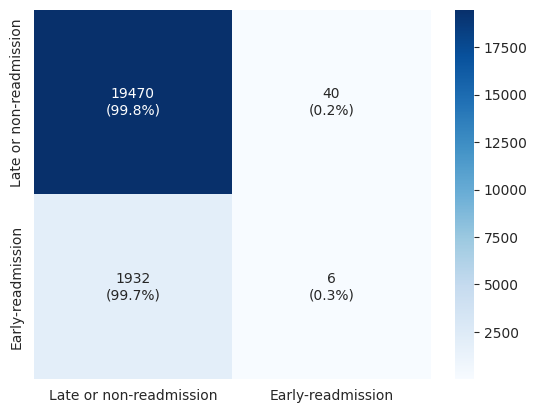

In [249]:
# Visualize confusion matrix with both absolute and percentage values
cm_none = confusion_matrix(y_test, y_test_pred_none)
cm_none_norm = confusion_matrix(y_test, y_test_pred_none, normalize='true')

annotations_none = np.array([
    [f"{val}\n({perc:.1%})" for val, perc in zip(row, norm_row)]
    for row, norm_row in zip(cm_none, cm_none_norm)
])

sns.heatmap(
    cm_none,
    annot=annotations_none,
    cmap='Blues',
    fmt='',
    xticklabels=['Late or non-readmission', 'Early-readmission'],
    yticklabels=['Late or non-readmission', 'Early-readmission']
)

## **3. Optuna Hyper-parameter Tuning | Undersampling**
Hyper-parameter tuning of the model using Optuna, and undersampling with RandomUnderSampler.

### 3.1 Objective & study setup
Preparing the objective function with all hyper-parameters, and creating/loading the Optuna study.

In [250]:
def objective(trial: optuna.Trial) -> float:
    # Hyperparameter search space
    params = {
        "n_estimators": 100,
        "max_depth": trial.suggest_int("max_depth", 4, 30, step=2),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 2, 60, step=2)
    }
    
    # Build pipeline
    pipeline = make_pipeline(
        RandomUnderSampler(random_state=RANDOM_STATE),
        RandomForestClassifier(**params, random_state=RANDOM_STATE)
    )
    
    # Define validation folds
    kf = StratifiedKFold(n_splits=5, shuffle=False)
    
    # Cross validation
    scores = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring=SCORING)

    print("Cross validation scores: {}".format(scores))
    print("Average score: {}".format(scores.mean()))

    return scores.mean()

In [251]:
# Set up study with name and storage
storage = JournalStorage(JournalFileBackend(STUDY_PATH_RUS))

study = optuna.create_study(
    direction="maximize",
    study_name=STUDY_NAME,
    storage=storage,
    load_if_exists=True,
    sampler=optuna.samplers.TPESampler(constant_liar=True, seed=RANDOM_STATE),
    pruner=optuna.pruners.SuccessiveHalvingPruner()
)

optuna.logging.set_verbosity(optuna.logging.INFO)

/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/optuna/_experimental.py:31: ExperimentalWarning:

Argument ``constant_liar`` is an experimental feature. The interface can change in the future.

[I 2024-12-31 13:08:58,384] A new study created in Journal with name: Diabetes_130-US


### 3.2 Hyper-parameter tuning
**(CAUTION)** <u>Do not run</u>, unless you already need to find the best parameters. If you already have bound the best model configuration, <u>run the section above</u> _(Objective & study setup)_.

In [252]:
study.optimize(
    objective,
    n_trials=N_TRIALS,
    n_jobs=-1 # Use all available cores
)

[I 2024-12-31 13:09:06,686] Trial 8 finished with value: 0.5039929076291205 and parameters: {'max_depth': 6, 'min_samples_leaf': 10}. Best is trial 8 with value: 0.5039929076291205.
[I 2024-12-31 13:09:06,861] Trial 4 finished with value: 0.4892520001961837 and parameters: {'max_depth': 30, 'min_samples_leaf': 50}. Best is trial 8 with value: 0.5039929076291205.
[I 2024-12-31 13:09:06,865] Trial 10 finished with value: 0.4897638219989869 and parameters: {'max_depth': 12, 'min_samples_leaf': 52}. Best is trial 8 with value: 0.5039929076291205.


Cross validation scores: [0.49162532 0.50868868 0.51745888 0.50383605 0.4983556 ]
Average score: 0.5039929076291205
Cross validation scores: [0.4808286  0.49150147 0.50286056 0.49001733 0.48105203]
Average score: 0.4892520001961837
Cross validation scores: [0.48079063 0.49282626 0.50028127 0.49071224 0.48420872]
Average score: 0.4897638219989869
Cross validation scores: [0.47768071 0.49316717 0.50503541 0.49330193 0.48426571]
Average score: 0.49069018565771394


[I 2024-12-31 13:09:06,900] Trial 3 finished with value: 0.49069018565771394 and parameters: {'max_depth': 20, 'min_samples_leaf': 60}. Best is trial 8 with value: 0.5039929076291205.
[I 2024-12-31 13:09:06,946] Trial 11 finished with value: 0.4889510816469877 and parameters: {'max_depth': 20, 'min_samples_leaf': 56}. Best is trial 8 with value: 0.5039929076291205.
[I 2024-12-31 13:09:06,959] Trial 2 finished with value: 0.48647806239543334 and parameters: {'max_depth': 26, 'min_samples_leaf': 24}. Best is trial 8 with value: 0.5039929076291205.
[I 2024-12-31 13:09:07,026] Trial 5 finished with value: 0.4881203687898223 and parameters: {'max_depth': 24, 'min_samples_leaf': 44}. Best is trial 8 with value: 0.5039929076291205.
[I 2024-12-31 13:09:07,076] Trial 7 finished with value: 0.4889121950789509 and parameters: {'max_depth': 14, 'min_samples_leaf': 32}. Best is trial 8 with value: 0.5039929076291205.


Cross validation scores: [0.48018508 0.4925594  0.49982972 0.48957582 0.4826054 ]
Average score: 0.4889510816469877
Cross validation scores: [0.48064474 0.48879652 0.49733608 0.48676065 0.47885232]
Average score: 0.48647806239543334
Cross validation scores: [0.48050158 0.49035352 0.5011106  0.49011459 0.47852156]
Average score: 0.4881203687898223
Cross validation scores: [0.48185797 0.49180934 0.49903879 0.49067737 0.4811775 ]
Average score: 0.4889121950789509


[I 2024-12-31 13:09:07,256] Trial 0 finished with value: 0.48663762669563393 and parameters: {'max_depth': 12, 'min_samples_leaf': 14}. Best is trial 8 with value: 0.5039929076291205.
[I 2024-12-31 13:09:07,356] Trial 6 finished with value: 0.4854999914409638 and parameters: {'max_depth': 16, 'min_samples_leaf': 18}. Best is trial 8 with value: 0.5039929076291205.


Cross validation scores: [0.4816547  0.48874194 0.49760114 0.48601841 0.47917193]
Average score: 0.48663762669563393
Cross validation scores: [0.48270064 0.48974973 0.49554959 0.48315083 0.47634917]
Average score: 0.4854999914409638


[I 2024-12-31 13:09:07,570] Trial 9 finished with value: 0.4907446044531838 and parameters: {'max_depth': 10, 'min_samples_leaf': 4}. Best is trial 8 with value: 0.5039929076291205.


Cross validation scores: [0.48022196 0.49498965 0.50002309 0.49400852 0.48447981]
Average score: 0.4907446044531838


[I 2024-12-31 13:09:08,328] Trial 1 finished with value: 0.4666791458693075 and parameters: {'max_depth': 28, 'min_samples_leaf': 4}. Best is trial 8 with value: 0.5039929076291205.


Cross validation scores: [0.46216629 0.46877262 0.47412951 0.46846161 0.4598657 ]
Average score: 0.4666791458693075


[I 2024-12-31 13:09:15,160] Trial 12 finished with value: 0.49261933468337415 and parameters: {'max_depth': 8, 'min_samples_leaf': 60}. Best is trial 8 with value: 0.5039929076291205.


Cross validation scores: [0.48339843 0.49325022 0.50242532 0.49787605 0.48614665]
Average score: 0.49261933468337415


[I 2024-12-31 13:09:15,368] Trial 21 finished with value: 0.5057084696557178 and parameters: {'max_depth': 4, 'min_samples_leaf': 24}. Best is trial 21 with value: 0.5057084696557178.
[I 2024-12-31 13:09:15,522] Trial 22 finished with value: 0.5058707557235679 and parameters: {'max_depth': 4, 'min_samples_leaf': 22}. Best is trial 22 with value: 0.5058707557235679.
[I 2024-12-31 13:09:15,546] Trial 15 finished with value: 0.48962088485825167 and parameters: {'max_depth': 20, 'min_samples_leaf': 54}. Best is trial 22 with value: 0.5058707557235679.


Cross validation scores: [0.49158743 0.50828814 0.52114977 0.50557751 0.50193951]
Average score: 0.5057084696557178
Cross validation scores: [0.4912449  0.50899136 0.52138573 0.50628164 0.50145015]
Average score: 0.5058707557235679
Cross validation scores: [0.48033849 0.49300622 0.50200976 0.48938289 0.48336707]
Average score: 0.48962088485825167


[I 2024-12-31 13:09:15,731] Trial 18 finished with value: 0.48894468757042364 and parameters: {'max_depth': 14, 'min_samples_leaf': 56}. Best is trial 22 with value: 0.5058707557235679.
[I 2024-12-31 13:09:15,739] Trial 14 finished with value: 0.48780347366571253 and parameters: {'max_depth': 12, 'min_samples_leaf': 32}. Best is trial 22 with value: 0.5058707557235679.
[I 2024-12-31 13:09:15,810] Trial 19 finished with value: 0.48905546593769617 and parameters: {'max_depth': 14, 'min_samples_leaf': 38}. Best is trial 22 with value: 0.5058707557235679.


Cross validation scores: [0.48018508 0.4925594  0.49982972 0.48954385 0.4826054 ]
Average score: 0.48894468757042364
Cross validation scores: [0.48276479 0.49068107 0.4970138  0.48860945 0.47994826]
Average score: 0.48780347366571253
Cross validation scores: [0.48375422 0.48873106 0.49865108 0.49122925 0.48291171]
Average score: 0.48905546593769617


[I 2024-12-31 13:09:16,077] Trial 17 finished with value: 0.4837829036543793 and parameters: {'max_depth': 22, 'min_samples_leaf': 16}. Best is trial 22 with value: 0.5058707557235679.


Cross validation scores: [0.48177515 0.48795594 0.49126343 0.48184271 0.47607728]
Average score: 0.4837829036543793


[I 2024-12-31 13:09:16,369] Trial 20 finished with value: 0.4843458786191485 and parameters: {'max_depth': 12, 'min_samples_leaf': 12}. Best is trial 22 with value: 0.5058707557235679.


Cross validation scores: [0.47877607 0.4867752  0.49135918 0.48452329 0.48029565]
Average score: 0.4843458786191485
Cross validation scores: [0.46792423 0.47781692 0.48169341 0.4734989  0.46739904]
Average score: 0.47366649850654535


[I 2024-12-31 13:09:16,555] Trial 13 finished with value: 0.47366649850654535 and parameters: {'max_depth': 22, 'min_samples_leaf': 6}. Best is trial 22 with value: 0.5058707557235679.
[I 2024-12-31 13:09:16,657] Trial 16 finished with value: 0.4749753659991104 and parameters: {'max_depth': 16, 'min_samples_leaf': 6}. Best is trial 22 with value: 0.5058707557235679.


Cross validation scores: [0.47055869 0.477593   0.48154369 0.4764863  0.46869515]
Average score: 0.4749753659991104


[I 2024-12-31 13:09:17,226] Trial 23 finished with value: 0.4961367721247879 and parameters: {'max_depth': 8, 'min_samples_leaf': 2}. Best is trial 22 with value: 0.5058707557235679.


Cross validation scores: [0.48846538 0.49765976 0.50673198 0.5006765  0.48715024]
Average score: 0.4961367721247879


[I 2024-12-31 13:09:23,371] Trial 25 finished with value: 0.5051070275468191 and parameters: {'max_depth': 4, 'min_samples_leaf': 26}. Best is trial 22 with value: 0.5058707557235679.
[I 2024-12-31 13:09:23,483] Trial 24 finished with value: 0.5006005026279847 and parameters: {'max_depth': 6, 'min_samples_leaf': 42}. Best is trial 22 with value: 0.5058707557235679.
[I 2024-12-31 13:09:23,526] Trial 26 finished with value: 0.5058707557235679 and parameters: {'max_depth': 4, 'min_samples_leaf': 22}. Best is trial 22 with value: 0.5058707557235679.


Cross validation scores: [0.49062231 0.50690625 0.52022157 0.50527431 0.50251069]
Average score: 0.5051070275468191
Cross validation scores: [0.49095289 0.50298874 0.51134893 0.50185352 0.49585843]
Average score: 0.5006005026279847
Cross validation scores: [0.4912449  0.50899136 0.52138573 0.50628164 0.50145015]
Average score: 0.5058707557235679


[I 2024-12-31 13:09:23,800] Trial 29 finished with value: 0.5049554814705074 and parameters: {'max_depth': 4, 'min_samples_leaf': 36}. Best is trial 22 with value: 0.5058707557235679.
[I 2024-12-31 13:09:23,881] Trial 28 finished with value: 0.5060657373392855 and parameters: {'max_depth': 4, 'min_samples_leaf': 20}. Best is trial 28 with value: 0.5060657373392855.


Cross validation scores: [0.49034751 0.505585   0.52046754 0.50501728 0.50336007]
Average score: 0.5049554814705074
Cross validation scores: [0.49155805 0.51058294 0.52231862 0.50393233 0.50193674]
Average score: 0.5060657373392855


[I 2024-12-31 13:09:24,495] Trial 27 finished with value: 0.4941798205328465 and parameters: {'max_depth': 8, 'min_samples_leaf': 28}. Best is trial 28 with value: 0.5060657373392855.
[I 2024-12-31 13:09:24,628] Trial 31 finished with value: 0.5006700288687586 and parameters: {'max_depth': 6, 'min_samples_leaf': 28}. Best is trial 28 with value: 0.5060657373392855.


Cross validation scores: [0.48826669 0.49412481 0.50650743 0.49683424 0.48516594]
Average score: 0.4941798205328465
Cross validation scores: [0.49126433 0.49654311 0.51344288 0.50319317 0.49890666]
Average score: 0.5006700288687586


[I 2024-12-31 13:09:25,049] Trial 32 finished with value: 0.5039929076291205 and parameters: {'max_depth': 6, 'min_samples_leaf': 10}. Best is trial 28 with value: 0.5060657373392855.
[I 2024-12-31 13:09:25,119] Trial 30 finished with value: 0.48996975473885057 and parameters: {'max_depth': 10, 'min_samples_leaf': 14}. Best is trial 28 with value: 0.5060657373392855.
[I 2024-12-31 13:09:25,136] Trial 33 finished with value: 0.5039929076291205 and parameters: {'max_depth': 6, 'min_samples_leaf': 10}. Best is trial 28 with value: 0.5060657373392855.


Cross validation scores: [0.49162532 0.50868868 0.51745888 0.50383605 0.4983556 ]
Average score: 0.5039929076291205
Cross validation scores: [0.48414328 0.49170518 0.50148698 0.49292162 0.47959172]
Average score: 0.48996975473885057
Cross validation scores: [0.49162532 0.50868868 0.51745888 0.50383605 0.4983556 ]
Average score: 0.5039929076291205


[I 2024-12-31 13:09:25,877] Trial 34 finished with value: 0.4914132240996924 and parameters: {'max_depth': 10, 'min_samples_leaf': 22}. Best is trial 28 with value: 0.5060657373392855.


Cross validation scores: [0.48498189 0.49427496 0.50407627 0.49254399 0.48118902]
Average score: 0.4914132240996924


[I 2024-12-31 13:09:26,272] Trial 35 finished with value: 0.4960499388757304 and parameters: {'max_depth': 8, 'min_samples_leaf': 18}. Best is trial 28 with value: 0.5060657373392855.


Cross validation scores: [0.48628831 0.49804909 0.50847871 0.50163922 0.48579437]
Average score: 0.4960499388757304


[I 2024-12-31 13:09:32,076] Trial 36 finished with value: 0.5051070275468191 and parameters: {'max_depth': 4, 'min_samples_leaf': 26}. Best is trial 28 with value: 0.5060657373392855.
[I 2024-12-31 13:09:32,249] Trial 38 finished with value: 0.5052868203132312 and parameters: {'max_depth': 4, 'min_samples_leaf': 32}. Best is trial 28 with value: 0.5060657373392855.


Cross validation scores: [0.49062231 0.50690625 0.52022157 0.50527431 0.50251069]
Average score: 0.5051070275468191
Cross validation scores: [0.49164538 0.50693474 0.51882266 0.50573512 0.5032962 ]
Average score: 0.5052868203132312


[I 2024-12-31 13:09:33,015] Trial 37 finished with value: 0.48630884635155186 and parameters: {'max_depth': 30, 'min_samples_leaf': 22}. Best is trial 28 with value: 0.5060657373392855.
[I 2024-12-31 13:09:33,048] Trial 39 finished with value: 0.48966706839335067 and parameters: {'max_depth': 28, 'min_samples_leaf': 46}. Best is trial 28 with value: 0.5060657373392855.


Cross validation scores: [0.48224237 0.49048206 0.49631599 0.48494149 0.47756231]
Average score: 0.48630884635155186
Cross validation scores: [0.48341818 0.49094213 0.50117721 0.49187539 0.48092243]
Average score: 0.48966706839335067


[I 2024-12-31 13:09:33,251] Trial 42 finished with value: 0.5058707557235679 and parameters: {'max_depth': 4, 'min_samples_leaf': 22}. Best is trial 28 with value: 0.5060657373392855.
[I 2024-12-31 13:09:33,425] Trial 40 finished with value: 0.4860160228733183 and parameters: {'max_depth': 18, 'min_samples_leaf': 20}. Best is trial 28 with value: 0.5060657373392855.


Cross validation scores: [0.4912449  0.50899136 0.52138573 0.50628164 0.50145015]
Average score: 0.5058707557235679
Cross validation scores: [0.47900008 0.49011624 0.49644382 0.48622495 0.47829502]
Average score: 0.4860160228733183


[I 2024-12-31 13:09:33,700] Trial 44 finished with value: 0.5044987274111147 and parameters: {'max_depth': 4, 'min_samples_leaf': 28}. Best is trial 28 with value: 0.5060657373392855.
[I 2024-12-31 13:09:33,715] Trial 41 finished with value: 0.48976848578007537 and parameters: {'max_depth': 10, 'min_samples_leaf': 36}. Best is trial 28 with value: 0.5060657373392855.


Cross validation scores: [0.48979742 0.50710783 0.51802766 0.50460323 0.5029575 ]
Average score: 0.5044987274111147
Cross validation scores: [0.48218137 0.49352109 0.50030124 0.4912478  0.48159093]
Average score: 0.48976848578007537
Cross validation scores: [0.49090405 0.50314721 0.51288469 0.50102392 0.49803864]
Average score: 0.5011997018328314


[I 2024-12-31 13:09:33,893] Trial 43 finished with value: 0.5011997018328314 and parameters: {'max_depth': 6, 'min_samples_leaf': 18}. Best is trial 28 with value: 0.5060657373392855.
[I 2024-12-31 13:09:34,242] Trial 45 finished with value: 0.4944062044381215 and parameters: {'max_depth': 8, 'min_samples_leaf': 24}. Best is trial 28 with value: 0.5060657373392855.


Cross validation scores: [0.48382659 0.49637931 0.50554993 0.49727734 0.48899785]
Average score: 0.4944062044381215


[I 2024-12-31 13:09:34,456] Trial 46 finished with value: 0.5047197343274507 and parameters: {'max_depth': 4, 'min_samples_leaf': 14}. Best is trial 28 with value: 0.5060657373392855.


Cross validation scores: [0.49027714 0.50761716 0.5213057  0.50296932 0.50142936]
Average score: 0.5047197343274507


[I 2024-12-31 13:09:35,300] Trial 47 finished with value: 0.5024739813112229 and parameters: {'max_depth': 6, 'min_samples_leaf': 20}. Best is trial 28 with value: 0.5060657373392855.


Cross validation scores: [0.48994222 0.50426933 0.51774833 0.50432492 0.49608511]
Average score: 0.5024739813112229


[I 2024-12-31 13:09:41,018] Trial 48 finished with value: 0.49412034141521344 and parameters: {'max_depth': 8, 'min_samples_leaf': 30}. Best is trial 28 with value: 0.5060657373392855.


Cross validation scores: [0.48490431 0.49489478 0.5084609  0.49721559 0.48512613]
Average score: 0.49412034141521344


[I 2024-12-31 13:09:41,663] Trial 49 finished with value: 0.4837829036543793 and parameters: {'max_depth': 26, 'min_samples_leaf': 16}. Best is trial 28 with value: 0.5060657373392855.
[I 2024-12-31 13:09:41,751] Trial 52 finished with value: 0.5058707557235679 and parameters: {'max_depth': 4, 'min_samples_leaf': 22}. Best is trial 28 with value: 0.5060657373392855.
[I 2024-12-31 13:09:41,834] Trial 53 finished with value: 0.5060657373392855 and parameters: {'max_depth': 4, 'min_samples_leaf': 20}. Best is trial 28 with value: 0.5060657373392855.


Cross validation scores: [0.48177515 0.48795594 0.49126343 0.48184271 0.47607728]
Average score: 0.4837829036543793
Cross validation scores: [0.4912449  0.50899136 0.52138573 0.50628164 0.50145015]
Average score: 0.5058707557235679
Cross validation scores: [0.49155805 0.51058294 0.52231862 0.50393233 0.50193674]
Average score: 0.5060657373392855


[I 2024-12-31 13:09:42,306] Trial 50 finished with value: 0.4919465295116018 and parameters: {'max_depth': 10, 'min_samples_leaf': 24}. Best is trial 28 with value: 0.5060657373392855.
[I 2024-12-31 13:09:42,389] Trial 51 finished with value: 0.4888209125076058 and parameters: {'max_depth': 12, 'min_samples_leaf': 34}. Best is trial 28 with value: 0.5060657373392855.


Cross validation scores: [0.48045207 0.49531642 0.50572217 0.49422781 0.48401418]
Average score: 0.4919465295116018
Cross validation scores: [0.48316378 0.48904462 0.49910677 0.4906858  0.48210359]
Average score: 0.4888209125076058


[I 2024-12-31 13:09:42,642] Trial 54 finished with value: 0.5022104543623656 and parameters: {'max_depth': 6, 'min_samples_leaf': 16}. Best is trial 28 with value: 0.5060657373392855.
[I 2024-12-31 13:09:42,648] Trial 57 finished with value: 0.5049028784876967 and parameters: {'max_depth': 4, 'min_samples_leaf': 30}. Best is trial 28 with value: 0.5060657373392855.
[I 2024-12-31 13:09:42,670] Trial 55 finished with value: 0.502026389576369 and parameters: {'max_depth': 6, 'min_samples_leaf': 26}. Best is trial 28 with value: 0.5060657373392855.


Cross validation scores: [0.49394497 0.5034338  0.51248678 0.50344292 0.4977438 ]
Average score: 0.5022104543623656
Cross validation scores: [0.49031886 0.5076848  0.51870803 0.50501728 0.50278542]
Average score: 0.5049028784876967
Cross validation scores: [0.49228089 0.49838325 0.51888723 0.50257822 0.49800237]
Average score: 0.502026389576369


[I 2024-12-31 13:09:43,151] Trial 56 finished with value: 0.49647749529178303 and parameters: {'max_depth': 8, 'min_samples_leaf': 8}. Best is trial 28 with value: 0.5060657373392855.
[I 2024-12-31 13:09:43,268] Trial 58 finished with value: 0.5018160361943865 and parameters: {'max_depth': 6, 'min_samples_leaf': 14}. Best is trial 28 with value: 0.5060657373392855.


Cross validation scores: [0.48838443 0.49600349 0.50686405 0.50190648 0.48922903]
Average score: 0.49647749529178303
Cross validation scores: [0.48990991 0.50598397 0.51498762 0.50319611 0.49500257]
Average score: 0.5018160361943865


[I 2024-12-31 13:09:44,001] Trial 59 finished with value: 0.5058707557235679 and parameters: {'max_depth': 4, 'min_samples_leaf': 22}. Best is trial 28 with value: 0.5060657373392855.


Cross validation scores: [0.4912449  0.50899136 0.52138573 0.50628164 0.50145015]
Average score: 0.5058707557235679


[I 2024-12-31 13:09:50,359] Trial 60 finished with value: 0.4944062044381215 and parameters: {'max_depth': 8, 'min_samples_leaf': 24}. Best is trial 28 with value: 0.5060657373392855.
[I 2024-12-31 13:09:50,498] Trial 62 finished with value: 0.5060657373392855 and parameters: {'max_depth': 4, 'min_samples_leaf': 20}. Best is trial 28 with value: 0.5060657373392855.


Cross validation scores: [0.48382659 0.49637931 0.50554993 0.49727734 0.48899785]
Average score: 0.4944062044381215
Cross validation scores: [0.49155805 0.51058294 0.52231862 0.50393233 0.50193674]
Average score: 0.5060657373392855


[I 2024-12-31 13:09:50,623] Trial 63 finished with value: 0.5060657373392855 and parameters: {'max_depth': 4, 'min_samples_leaf': 20}. Best is trial 28 with value: 0.5060657373392855.


Cross validation scores: [0.49155805 0.51058294 0.52231862 0.50393233 0.50193674]
Average score: 0.5060657373392855


[I 2024-12-31 13:09:51,058] Trial 64 finished with value: 0.5055174443987073 and parameters: {'max_depth': 4, 'min_samples_leaf': 12}. Best is trial 28 with value: 0.5060657373392855.
[I 2024-12-31 13:09:51,132] Trial 61 finished with value: 0.4911297312535413 and parameters: {'max_depth': 10, 'min_samples_leaf': 40}. Best is trial 28 with value: 0.5060657373392855.


Cross validation scores: [0.49161654 0.50810843 0.52170389 0.50464786 0.5015105 ]
Average score: 0.5055174443987073
Cross validation scores: [0.48339843 0.49356077 0.5016862  0.49333956 0.48366369]
Average score: 0.4911297312535413


[I 2024-12-31 13:09:51,589] Trial 65 finished with value: 0.5011997018328314 and parameters: {'max_depth': 6, 'min_samples_leaf': 18}. Best is trial 28 with value: 0.5060657373392855.
[I 2024-12-31 13:09:51,747] Trial 69 finished with value: 0.5055174443987073 and parameters: {'max_depth': 4, 'min_samples_leaf': 12}. Best is trial 28 with value: 0.5060657373392855.


Cross validation scores: [0.49090405 0.50314721 0.51288469 0.50102392 0.49803864]
Average score: 0.5011997018328314
Cross validation scores: [0.49161654 0.50810843 0.52170389 0.50464786 0.5015105 ]
Average score: 0.5055174443987073
Cross validation scores: [0.49304881 0.50283011 0.51770061 0.50321684 0.49740719]
Average score: 0.5028407111087998


[I 2024-12-31 13:09:51,810] Trial 67 finished with value: 0.5028407111087998 and parameters: {'max_depth': 6, 'min_samples_leaf': 22}. Best is trial 28 with value: 0.5060657373392855.
[I 2024-12-31 13:09:51,929] Trial 68 finished with value: 0.5028407111087998 and parameters: {'max_depth': 6, 'min_samples_leaf': 22}. Best is trial 28 with value: 0.5060657373392855.
[I 2024-12-31 13:09:51,973] Trial 66 finished with value: 0.5028407111087998 and parameters: {'max_depth': 6, 'min_samples_leaf': 22}. Best is trial 28 with value: 0.5060657373392855.


Cross validation scores: [0.49304881 0.50283011 0.51770061 0.50321684 0.49740719]
Average score: 0.5028407111087998
Cross validation scores: [0.49304881 0.50283011 0.51770061 0.50321684 0.49740719]
Average score: 0.5028407111087998


[I 2024-12-31 13:09:52,972] Trial 70 finished with value: 0.4877498124341383 and parameters: {'max_depth': 18, 'min_samples_leaf': 26}. Best is trial 28 with value: 0.5060657373392855.


Cross validation scores: [0.48248455 0.48991308 0.49950815 0.48511326 0.48173002]
Average score: 0.4877498124341383


[I 2024-12-31 13:09:53,474] Trial 71 finished with value: 0.4960499388757304 and parameters: {'max_depth': 8, 'min_samples_leaf': 18}. Best is trial 28 with value: 0.5060657373392855.


Cross validation scores: [0.48628831 0.49804909 0.50847871 0.50163922 0.48579437]
Average score: 0.4960499388757304


[I 2024-12-31 13:09:59,196] Trial 72 finished with value: 0.5044987274111147 and parameters: {'max_depth': 4, 'min_samples_leaf': 28}. Best is trial 28 with value: 0.5060657373392855.
[I 2024-12-31 13:09:59,248] Trial 74 finished with value: 0.5060657373392855 and parameters: {'max_depth': 4, 'min_samples_leaf': 20}. Best is trial 28 with value: 0.5060657373392855.
[I 2024-12-31 13:09:59,278] Trial 73 finished with value: 0.5060657373392855 and parameters: {'max_depth': 4, 'min_samples_leaf': 20}. Best is trial 28 with value: 0.5060657373392855.


Cross validation scores: [0.48979742 0.50710783 0.51802766 0.50460323 0.5029575 ]
Average score: 0.5044987274111147
Cross validation scores: [0.49155805 0.51058294 0.52231862 0.50393233 0.50193674]
Average score: 0.5060657373392855
Cross validation scores: [0.49155805 0.51058294 0.52231862 0.50393233 0.50193674]
Average score: 0.5060657373392855


[I 2024-12-31 13:09:59,854] Trial 76 finished with value: 0.5060657373392855 and parameters: {'max_depth': 4, 'min_samples_leaf': 20}. Best is trial 28 with value: 0.5060657373392855.


Cross validation scores: [0.49155805 0.51058294 0.52231862 0.50393233 0.50193674]
Average score: 0.5060657373392855


[I 2024-12-31 13:10:00,487] Trial 78 finished with value: 0.5051528169248176 and parameters: {'max_depth': 4, 'min_samples_leaf': 18}. Best is trial 28 with value: 0.5060657373392855.
[I 2024-12-31 13:10:00,547] Trial 80 finished with value: 0.5054996565138737 and parameters: {'max_depth': 4, 'min_samples_leaf': 16}. Best is trial 28 with value: 0.5060657373392855.


Cross validation scores: [0.48958706 0.51093151 0.51976522 0.50311494 0.50236536]
Average score: 0.5051528169248176
Cross validation scores: [0.48926276 0.51168985 0.52102317 0.50400862 0.50151388]
Average score: 0.5054996565138737


[I 2024-12-31 13:10:00,788] Trial 77 finished with value: 0.5018160361943865 and parameters: {'max_depth': 6, 'min_samples_leaf': 14}. Best is trial 28 with value: 0.5060657373392855.


Cross validation scores: [0.48990991 0.50598397 0.51498762 0.50319611 0.49500257]
Average score: 0.5018160361943865


[I 2024-12-31 13:10:01,003] Trial 75 finished with value: 0.4837829036543793 and parameters: {'max_depth': 22, 'min_samples_leaf': 16}. Best is trial 28 with value: 0.5060657373392855.


Cross validation scores: [0.48177515 0.48795594 0.49126343 0.48184271 0.47607728]
Average score: 0.4837829036543793


[I 2024-12-31 13:10:01,370] Trial 79 finished with value: 0.4944062044381215 and parameters: {'max_depth': 8, 'min_samples_leaf': 24}. Best is trial 28 with value: 0.5060657373392855.


Cross validation scores: [0.48382659 0.49637931 0.50554993 0.49727734 0.48899785]
Average score: 0.4944062044381215


[I 2024-12-31 13:10:01,712] Trial 82 finished with value: 0.5051070275468191 and parameters: {'max_depth': 4, 'min_samples_leaf': 26}. Best is trial 28 with value: 0.5060657373392855.
[I 2024-12-31 13:10:01,788] Trial 81 finished with value: 0.4837829036543793 and parameters: {'max_depth': 24, 'min_samples_leaf': 16}. Best is trial 28 with value: 0.5060657373392855.


Cross validation scores: [0.49062231 0.50690625 0.52022157 0.50527431 0.50251069]
Average score: 0.5051070275468191
Cross validation scores: [0.48177515 0.48795594 0.49126343 0.48184271 0.47607728]
Average score: 0.4837829036543793


[I 2024-12-31 13:10:02,489] Trial 83 finished with value: 0.5024739813112229 and parameters: {'max_depth': 6, 'min_samples_leaf': 20}. Best is trial 28 with value: 0.5060657373392855.


Cross validation scores: [0.48994222 0.50426933 0.51774833 0.50432492 0.49608511]
Average score: 0.5024739813112229


[I 2024-12-31 13:10:08,010] Trial 84 finished with value: 0.5049028784876967 and parameters: {'max_depth': 4, 'min_samples_leaf': 30}. Best is trial 28 with value: 0.5060657373392855.


Cross validation scores: [0.49031886 0.5076848  0.51870803 0.50501728 0.50278542]
Average score: 0.5049028784876967


[I 2024-12-31 13:10:08,266] Trial 86 finished with value: 0.5024739813112229 and parameters: {'max_depth': 6, 'min_samples_leaf': 20}. Best is trial 28 with value: 0.5060657373392855.
[I 2024-12-31 13:10:08,271] Trial 85 finished with value: 0.5024739813112229 and parameters: {'max_depth': 6, 'min_samples_leaf': 20}. Best is trial 28 with value: 0.5060657373392855.


Cross validation scores: [0.48994222 0.50426933 0.51774833 0.50432492 0.49608511]
Average score: 0.5024739813112229
Cross validation scores: [0.48994222 0.50426933 0.51774833 0.50432492 0.49608511]
Average score: 0.5024739813112229
Cross validation scores: [0.49155805 0.51058294 0.52231862 0.50393233 0.50193674]
Average score: 0.5060657373392855


[I 2024-12-31 13:10:08,475] Trial 87 finished with value: 0.5060657373392855 and parameters: {'max_depth': 4, 'min_samples_leaf': 20}. Best is trial 28 with value: 0.5060657373392855.
[I 2024-12-31 13:10:08,997] Trial 88 finished with value: 0.5051528169248176 and parameters: {'max_depth': 4, 'min_samples_leaf': 18}. Best is trial 28 with value: 0.5060657373392855.


Cross validation scores: [0.48958706 0.51093151 0.51976522 0.50311494 0.50236536]
Average score: 0.5051528169248176


[I 2024-12-31 13:10:09,256] Trial 90 finished with value: 0.5047197343274507 and parameters: {'max_depth': 4, 'min_samples_leaf': 14}. Best is trial 28 with value: 0.5060657373392855.


Cross validation scores: [0.49027714 0.50761716 0.5213057  0.50296932 0.50142936]
Average score: 0.5047197343274507


[I 2024-12-31 13:10:09,554] Trial 89 finished with value: 0.49617004857802505 and parameters: {'max_depth': 8, 'min_samples_leaf': 12}. Best is trial 28 with value: 0.5060657373392855.
[I 2024-12-31 13:10:09,591] Trial 92 finished with value: 0.5060657373392855 and parameters: {'max_depth': 4, 'min_samples_leaf': 20}. Best is trial 28 with value: 0.5060657373392855.


Cross validation scores: [0.49114951 0.49602898 0.50569523 0.49867721 0.48929931]
Average score: 0.49617004857802505
Cross validation scores: [0.49155805 0.51058294 0.52231862 0.50393233 0.50193674]
Average score: 0.5060657373392855


[I 2024-12-31 13:10:09,923] Trial 93 finished with value: 0.5057084696557178 and parameters: {'max_depth': 4, 'min_samples_leaf': 24}. Best is trial 28 with value: 0.5060657373392855.
[I 2024-12-31 13:10:10,040] Trial 94 finished with value: 0.5011997018328314 and parameters: {'max_depth': 6, 'min_samples_leaf': 18}. Best is trial 28 with value: 0.5060657373392855.


Cross validation scores: [0.49158743 0.50828814 0.52114977 0.50557751 0.50193951]
Average score: 0.5057084696557178
Cross validation scores: [0.49090405 0.50314721 0.51288469 0.50102392 0.49803864]
Average score: 0.5011997018328314
Cross validation scores: [0.47749551 0.47998433 0.48835491 0.47898688 0.47028039]
Average score: 0.4790204038024424


[I 2024-12-31 13:10:10,119] Trial 91 finished with value: 0.4790204038024424 and parameters: {'max_depth': 16, 'min_samples_leaf': 10}. Best is trial 28 with value: 0.5060657373392855.
[I 2024-12-31 13:10:10,149] Trial 95 finished with value: 0.5044987274111147 and parameters: {'max_depth': 4, 'min_samples_leaf': 28}. Best is trial 28 with value: 0.5060657373392855.


Cross validation scores: [0.48979742 0.50710783 0.51802766 0.50460323 0.5029575 ]
Average score: 0.5044987274111147


[I 2024-12-31 13:10:11,506] Trial 98 finished with value: 0.5057084696557178 and parameters: {'max_depth': 4, 'min_samples_leaf': 24}. Best is trial 28 with value: 0.5060657373392855.
[I 2024-12-31 13:10:11,529] Trial 97 finished with value: 0.5057084696557178 and parameters: {'max_depth': 4, 'min_samples_leaf': 24}. Best is trial 28 with value: 0.5060657373392855.
[I 2024-12-31 13:10:11,613] Trial 96 finished with value: 0.502026389576369 and parameters: {'max_depth': 6, 'min_samples_leaf': 26}. Best is trial 28 with value: 0.5060657373392855.
[I 2024-12-31 13:10:11,699] Trial 99 finished with value: 0.5024739813112229 and parameters: {'max_depth': 6, 'min_samples_leaf': 20}. Best is trial 28 with value: 0.5060657373392855.


Cross validation scores: [0.49158743 0.50828814 0.52114977 0.50557751 0.50193951]
Average score: 0.5057084696557178
Cross validation scores: [0.49158743 0.50828814 0.52114977 0.50557751 0.50193951]
Average score: 0.5057084696557178
Cross validation scores: [0.49228089 0.49838325 0.51888723 0.50257822 0.49800237]
Average score: 0.502026389576369
Cross validation scores: [0.48994222 0.50426933 0.51774833 0.50432492 0.49608511]
Average score: 0.5024739813112229


In [253]:
print('Best Trial: {}'.format(study.best_trial.number))
print('Best Parameters: {}'.format(study.best_params))
print('Best Value: {}'.format(study.best_value))

Best Trial: 28
Best Parameters: {'max_depth': 4, 'min_samples_leaf': 20}
Best Value: 0.5060657373392855


### 3.3 Optuna Visualizations
Visualizing hyper-parameter tuning results obtained by running Optuna.

In [254]:
optuna.visualization.plot_optimization_history(study)

In [255]:
optuna.visualization.plot_slice(study)

In [256]:
optuna.visualization.plot_param_importances(study)

In [257]:
optuna.visualization.plot_parallel_coordinate(study)

In [258]:
optuna.visualization.plot_contour(study)

In [259]:
optuna.visualization.plot_timeline(study)

### 3.4 Fitting Best Model
Fitting the final model using the best hyper-parameters found by Optuna.

In [260]:
# Fit best model on the training set
best_params = study.best_params

pipeline_rus = make_pipeline(
    RandomUnderSampler(random_state=RANDOM_STATE),
    RandomForestClassifier(**best_params, random_state=RANDOM_STATE)
)

pipeline_rus.fit(X_train, y_train)

Pipeline(steps=[('randomundersampler', RandomUnderSampler(random_state=38)),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=4, min_samples_leaf=20,
                                        random_state=38))])

In [261]:
# Predictions
y_train_pred_rus = pipeline_rus.predict(X_train)
y_test_pred_rus = pipeline_rus.predict(X_test)

In [262]:
ac_train_rus = accuracy_score(y_train, y_train_pred_rus)
ac_test_rus = accuracy_score(y_test, y_test_pred_rus)

print('Train accuracy: ', ac_train_rus)
print('Test accuracy: ', ac_test_rus)

Train accuracy:  0.642721550604456
Test accuracy:  0.6382879522566207


In [263]:
# Visualize precision, recall, F1-score
print(classification_report(
    y_test, y_test_pred_rus,
    target_names=['Late or non-readmission', 'Early-readmission']
))

                         precision    recall  f1-score   support

Late or non-readmission       0.93      0.65      0.77     19510
      Early-readmission       0.13      0.55      0.21      1938

               accuracy                           0.64     21448
              macro avg       0.53      0.60      0.49     21448
           weighted avg       0.86      0.64      0.72     21448



In [264]:
# Compute precision, recall, F1-score, ROC-AUC-score, and accuracy
recall_rus = recall_score(y_test, y_test_pred_rus, average='macro')
precision_rus = precision_score(y_test, y_test_pred_rus, average='macro')
f1_rus = f1_score(y_test, y_test_pred_rus, average='macro')
roc_auc_rus = roc_auc_score(y_test, y_test_pred_rus, average='macro')
accuracy_rus = accuracy_score(y_test, y_test_pred_rus)

<Axes: >

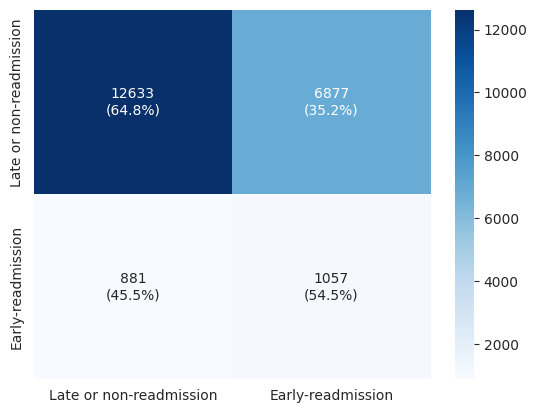

In [265]:
# Visualize confusion matrix with both absolute and percentage values
cm_rus = confusion_matrix(y_test, y_test_pred_rus)
cm_rus_norm = confusion_matrix(y_test, y_test_pred_rus, normalize='true')

annotations_rus = np.array([
    [f"{val}\n({perc:.1%})" for val, perc in zip(row, norm_row)]
    for row, norm_row in zip(cm_rus, cm_rus_norm)
])

sns.heatmap(
    cm_rus,
    annot=annotations_rus,
    cmap='Blues',
    fmt='',
    xticklabels=['Late or non-readmission', 'Early-readmission'],
    yticklabels=['Late or non-readmission', 'Early-readmission']
)

## **4. Optuna Hyper-parameter Tuning | SMOTE**
Hyper-parameter tuning of the model using Optuna, and oversampling with SMOTE.

### 4.1 Objective & study setup
Preparing the objective function with all hyper-parameters, and creating/loading the Optuna study.

In [266]:
def objective(trial: optuna.Trial) -> float:
    # Hyperparameter search space
    params = {
        "n_estimators": 100,
        "max_depth": trial.suggest_int("max_depth", 14, 40, step=2),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 16, 100, step=2)
    }
    
    # Build pipeline
    pipeline = make_pipeline(
        SMOTE(random_state=RANDOM_STATE),
        RandomForestClassifier(**params, random_state=RANDOM_STATE)
    )
    
    # Define validation folds
    kf = StratifiedKFold(n_splits=5, shuffle=False)
    
    # Cross validation
    scores = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring=SCORING)

    print("Cross validation scores: {}".format(scores))
    print("Average score: {}".format(scores.mean()))

    return scores.mean()

In [267]:
# Set up study with name and storage
storage = JournalStorage(JournalFileBackend(STUDY_PATH_SMOTE))

study = optuna.create_study(
    direction="maximize",
    study_name=STUDY_NAME,
    storage=storage,
    load_if_exists=True,
    sampler=optuna.samplers.TPESampler(constant_liar=True, seed=RANDOM_STATE),
    pruner=optuna.pruners.SuccessiveHalvingPruner()
)

optuna.logging.set_verbosity(optuna.logging.INFO)

/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/optuna/_experimental.py:31: ExperimentalWarning:

Argument ``constant_liar`` is an experimental feature. The interface can change in the future.

[I 2024-12-31 13:10:12,478] A new study created in Journal with name: Diabetes_130-US


### 4.2 Hyper-parameter tuning
**(CAUTION)** <u>Do not run</u>, unless you already need to find the best parameters. If you already have bound the best model configuration, <u>run the section above</u> _(Objective & study setup)_.

In [268]:
study.optimize(
    objective,
    n_trials=N_TRIALS,
    n_jobs=-1 # Use all available cores
)

[I 2024-12-31 13:10:44,117] Trial 5 finished with value: 0.540128171199201 and parameters: {'max_depth': 40, 'min_samples_leaf': 98}. Best is trial 5 with value: 0.540128171199201.


Cross validation scores: [0.53738353 0.54812829 0.543004   0.5396152  0.53250984]
Average score: 0.540128171199201


[I 2024-12-31 13:10:44,434] Trial 2 finished with value: 0.5402200438310103 and parameters: {'max_depth': 18, 'min_samples_leaf': 78}. Best is trial 2 with value: 0.5402200438310103.


Cross validation scores: [0.53672596 0.54211948 0.54504655 0.54236831 0.53483992]
Average score: 0.5402200438310103


[I 2024-12-31 13:10:44,835] Trial 6 finished with value: 0.5412941727483002 and parameters: {'max_depth': 40, 'min_samples_leaf': 80}. Best is trial 6 with value: 0.5412941727483002.
[I 2024-12-31 13:10:44,914] Trial 1 finished with value: 0.5401755706615623 and parameters: {'max_depth': 40, 'min_samples_leaf': 74}. Best is trial 6 with value: 0.5412941727483002.
[I 2024-12-31 13:10:44,988] Trial 7 finished with value: 0.5412159287388215 and parameters: {'max_depth': 22, 'min_samples_leaf': 74}. Best is trial 6 with value: 0.5412941727483002.


Cross validation scores: [0.5387873  0.54772344 0.547646   0.53922875 0.53308537]
Average score: 0.5412941727483002
Cross validation scores: [0.5372131  0.54702568 0.54469331 0.53754318 0.53440259]
Average score: 0.5401755706615623
Cross validation scores: [0.53745129 0.54613264 0.54587843 0.54193832 0.53467896]
Average score: 0.5412159287388215


[I 2024-12-31 13:10:45,403] Trial 4 finished with value: 0.5396927733014086 and parameters: {'max_depth': 22, 'min_samples_leaf': 66}. Best is trial 6 with value: 0.5412941727483002.


Cross validation scores: [0.53755406 0.54307397 0.54206853 0.54284243 0.53292488]
Average score: 0.5396927733014086


[I 2024-12-31 13:10:47,239] Trial 3 finished with value: 0.536080755954058 and parameters: {'max_depth': 26, 'min_samples_leaf': 38}. Best is trial 6 with value: 0.5412941727483002.


Cross validation scores: [0.53759656 0.53854034 0.53694037 0.53988625 0.52744027]
Average score: 0.536080755954058


[I 2024-12-31 13:10:47,494] Trial 10 finished with value: 0.5375293052357797 and parameters: {'max_depth': 30, 'min_samples_leaf': 42}. Best is trial 6 with value: 0.5412941727483002.
[I 2024-12-31 13:10:47,607] Trial 11 finished with value: 0.5344415580341411 and parameters: {'max_depth': 22, 'min_samples_leaf': 36}. Best is trial 6 with value: 0.5412941727483002.


Cross validation scores: [0.5357112  0.54111727 0.54142769 0.53823242 0.53115795]
Average score: 0.5375293052357797
Cross validation scores: [0.53542595 0.53993192 0.53193437 0.53629963 0.52861591]
Average score: 0.5344415580341411


[I 2024-12-31 13:10:47,987] Trial 0 finished with value: 0.5360846064291117 and parameters: {'max_depth': 22, 'min_samples_leaf': 30}. Best is trial 6 with value: 0.5412941727483002.


Cross validation scores: [0.53313308 0.54113607 0.53809357 0.5393969  0.52866341]
Average score: 0.5360846064291117


[I 2024-12-31 13:10:48,720] Trial 8 finished with value: 0.5321364235539475 and parameters: {'max_depth': 36, 'min_samples_leaf': 24}. Best is trial 6 with value: 0.5412941727483002.


Cross validation scores: [0.53100935 0.53535995 0.53050038 0.53684116 0.52697127]
Average score: 0.5321364235539475


[I 2024-12-31 13:10:49,741] Trial 9 finished with value: 0.5270484364072716 and parameters: {'max_depth': 40, 'min_samples_leaf': 16}. Best is trial 6 with value: 0.5412941727483002.


Cross validation scores: [0.52842692 0.53708677 0.5268476  0.52573657 0.51714431]
Average score: 0.5270484364072716


[I 2024-12-31 13:11:14,630] Trial 14 finished with value: 0.5422117049087894 and parameters: {'max_depth': 14, 'min_samples_leaf': 60}. Best is trial 14 with value: 0.5422117049087894.
[I 2024-12-31 13:11:14,798] Trial 16 finished with value: 0.542170795935027 and parameters: {'max_depth': 14, 'min_samples_leaf': 76}. Best is trial 14 with value: 0.5422117049087894.


Cross validation scores: [0.53989426 0.54172538 0.54834234 0.54481472 0.53628183]
Average score: 0.5422117049087894
Cross validation scores: [0.53586095 0.54410326 0.55450538 0.54055543 0.53582896]
Average score: 0.542170795935027


[I 2024-12-31 13:11:15,355] Trial 12 finished with value: 0.5401893908981596 and parameters: {'max_depth': 32, 'min_samples_leaf': 88}. Best is trial 14 with value: 0.5422117049087894.


Cross validation scores: [0.53725303 0.54291727 0.54855427 0.54105852 0.53116387]
Average score: 0.5401893908981596


[I 2024-12-31 13:11:15,960] Trial 15 finished with value: 0.5396280493660923 and parameters: {'max_depth': 30, 'min_samples_leaf': 90}. Best is trial 14 with value: 0.5422117049087894.


Cross validation scores: [0.53732291 0.54088987 0.5503174  0.53857124 0.53103882]
Average score: 0.5396280493660923


[I 2024-12-31 13:11:16,514] Trial 17 finished with value: 0.5401893908981596 and parameters: {'max_depth': 34, 'min_samples_leaf': 88}. Best is trial 14 with value: 0.5422117049087894.
[I 2024-12-31 13:11:16,567] Trial 13 finished with value: 0.539253519695037 and parameters: {'max_depth': 22, 'min_samples_leaf': 58}. Best is trial 14 with value: 0.5422117049087894.


Cross validation scores: [0.53725303 0.54291727 0.54855427 0.54105852 0.53116387]
Average score: 0.5401893908981596
Cross validation scores: [0.54267073 0.54142198 0.54361044 0.53801832 0.53054613]
Average score: 0.539253519695037


[I 2024-12-31 13:11:18,553] Trial 20 finished with value: 0.5408540556946877 and parameters: {'max_depth': 14, 'min_samples_leaf': 30}. Best is trial 14 with value: 0.5422117049087894.


Cross validation scores: [0.54309826 0.53921393 0.54397557 0.54276182 0.5352207 ]
Average score: 0.5408540556946877


[I 2024-12-31 13:11:20,874] Trial 22 finished with value: 0.5398896333740181 and parameters: {'max_depth': 26, 'min_samples_leaf': 68}. Best is trial 14 with value: 0.5422117049087894.
[I 2024-12-31 13:11:20,930] Trial 23 finished with value: 0.5399025979111093 and parameters: {'max_depth': 18, 'min_samples_leaf': 84}. Best is trial 14 with value: 0.5422117049087894.


Cross validation scores: [0.5367785  0.54463947 0.54571118 0.53987552 0.5324435 ]
Average score: 0.5398896333740181
Cross validation scores: [0.53773212 0.54474532 0.54698285 0.53774754 0.53230516]
Average score: 0.5399025979111093


[I 2024-12-31 13:11:21,251] Trial 21 finished with value: 0.5391679003555774 and parameters: {'max_depth': 36, 'min_samples_leaf': 50}. Best is trial 14 with value: 0.5422117049087894.


Cross validation scores: [0.54115978 0.54205734 0.54219369 0.5379875  0.53244119]
Average score: 0.5391679003555774


[I 2024-12-31 13:11:22,630] Trial 18 finished with value: 0.5340042414794798 and parameters: {'max_depth': 28, 'min_samples_leaf': 24}. Best is trial 14 with value: 0.5422117049087894.


Cross validation scores: [0.53157486 0.53646146 0.53251485 0.53990337 0.52956668]
Average score: 0.5340042414794798


[I 2024-12-31 13:11:24,119] Trial 19 finished with value: 0.5266586225155987 and parameters: {'max_depth': 38, 'min_samples_leaf': 18}. Best is trial 14 with value: 0.5422117049087894.


Cross validation scores: [0.52820254 0.52959178 0.52728001 0.53059483 0.51762396]
Average score: 0.5266586225155987


[I 2024-12-31 13:11:45,041] Trial 25 finished with value: 0.5425400298879972 and parameters: {'max_depth': 14, 'min_samples_leaf': 62}. Best is trial 25 with value: 0.5425400298879972.


Cross validation scores: [0.54060455 0.54114586 0.5487376  0.54316343 0.53904871]
Average score: 0.5425400298879972


[I 2024-12-31 13:11:46,854] Trial 27 finished with value: 0.5407119070135524 and parameters: {'max_depth': 16, 'min_samples_leaf': 66}. Best is trial 25 with value: 0.5425400298879972.
[I 2024-12-31 13:11:46,894] Trial 24 finished with value: 0.537891774589727 and parameters: {'max_depth': 18, 'min_samples_leaf': 54}. Best is trial 25 with value: 0.5425400298879972.


Cross validation scores: [0.54176515 0.54220596 0.54544615 0.54092322 0.53321906]
Average score: 0.5407119070135524
Cross validation scores: [0.53881772 0.5414128  0.54034095 0.53904612 0.52984129]
Average score: 0.537891774589727


[I 2024-12-31 13:11:47,315] Trial 29 finished with value: 0.5402887859587955 and parameters: {'max_depth': 24, 'min_samples_leaf': 100}. Best is trial 25 with value: 0.5425400298879972.
[I 2024-12-31 13:11:47,377] Trial 28 finished with value: 0.5405770670800447 and parameters: {'max_depth': 20, 'min_samples_leaf': 94}. Best is trial 25 with value: 0.5425400298879972.


Cross validation scores: [0.53499675 0.54544715 0.54715419 0.5395143  0.53433153]
Average score: 0.5402887859587955
Cross validation scores: [0.53739282 0.54488911 0.54896129 0.53977919 0.53186293]
Average score: 0.5405770670800447


[I 2024-12-31 13:11:47,618] Trial 26 finished with value: 0.5401508189797444 and parameters: {'max_depth': 16, 'min_samples_leaf': 48}. Best is trial 25 with value: 0.5425400298879972.


Cross validation scores: [0.54083006 0.54156471 0.54265711 0.54055134 0.53515087]
Average score: 0.5401508189797444


[I 2024-12-31 13:11:48,716] Trial 30 finished with value: 0.5418398037006932 and parameters: {'max_depth': 14, 'min_samples_leaf': 72}. Best is trial 25 with value: 0.5425400298879972.


Cross validation scores: [0.53922202 0.54231471 0.54842024 0.54313036 0.5361117 ]
Average score: 0.5418398037006932


[I 2024-12-31 13:11:52,105] Trial 31 finished with value: 0.5406558168547043 and parameters: {'max_depth': 16, 'min_samples_leaf': 58}. Best is trial 25 with value: 0.5425400298879972.


Cross validation scores: [0.53509652 0.5413927  0.54907188 0.54227787 0.53544011]
Average score: 0.5406558168547043


[I 2024-12-31 13:11:52,439] Trial 32 finished with value: 0.5415719735769711 and parameters: {'max_depth': 20, 'min_samples_leaf': 80}. Best is trial 25 with value: 0.5425400298879972.


Cross validation scores: [0.53871174 0.54627719 0.54876607 0.53989677 0.53420809]
Average score: 0.5415719735769711


[I 2024-12-31 13:11:52,917] Trial 33 finished with value: 0.5406866752213534 and parameters: {'max_depth': 24, 'min_samples_leaf': 82}. Best is trial 25 with value: 0.5425400298879972.


Cross validation scores: [0.5390453  0.5447069  0.54435009 0.54079044 0.53454065]
Average score: 0.5406866752213534


[I 2024-12-31 13:11:54,093] Trial 34 finished with value: 0.5409053883550634 and parameters: {'max_depth': 20, 'min_samples_leaf': 76}. Best is trial 25 with value: 0.5425400298879972.


Cross validation scores: [0.54039673 0.54496389 0.54635208 0.53654172 0.53627253]
Average score: 0.5409053883550634


[I 2024-12-31 13:11:56,464] Trial 35 finished with value: 0.5410741183325471 and parameters: {'max_depth': 28, 'min_samples_leaf': 68}. Best is trial 25 with value: 0.5425400298879972.


Cross validation scores: [0.53940311 0.54524702 0.54584206 0.54083469 0.53404371]
Average score: 0.5410741183325471


[I 2024-12-31 13:12:14,811] Trial 36 finished with value: 0.5425400298879972 and parameters: {'max_depth': 14, 'min_samples_leaf': 62}. Best is trial 25 with value: 0.5425400298879972.


Cross validation scores: [0.54060455 0.54114586 0.5487376  0.54316343 0.53904871]
Average score: 0.5425400298879972


[I 2024-12-31 13:12:17,169] Trial 39 finished with value: 0.5425400298879972 and parameters: {'max_depth': 14, 'min_samples_leaf': 62}. Best is trial 25 with value: 0.5425400298879972.


Cross validation scores: [0.54060455 0.54114586 0.5487376  0.54316343 0.53904871]
Average score: 0.5425400298879972


[I 2024-12-31 13:12:18,035] Trial 41 finished with value: 0.5408238519715793 and parameters: {'max_depth': 16, 'min_samples_leaf': 72}. Best is trial 25 with value: 0.5425400298879972.


Cross validation scores: [0.53755009 0.54481784 0.54615419 0.54025131 0.53534583]
Average score: 0.5408238519715793


[I 2024-12-31 13:12:18,334] Trial 38 finished with value: 0.5406636037761116 and parameters: {'max_depth': 16, 'min_samples_leaf': 44}. Best is trial 25 with value: 0.5425400298879972.
[I 2024-12-31 13:12:18,371] Trial 42 finished with value: 0.5418398037006932 and parameters: {'max_depth': 14, 'min_samples_leaf': 72}. Best is trial 25 with value: 0.5425400298879972.


Cross validation scores: [0.54095732 0.5407453  0.54671081 0.54318149 0.53172311]
Average score: 0.5406636037761116
Cross validation scores: [0.53922202 0.54231471 0.54842024 0.54313036 0.5361117 ]
Average score: 0.5418398037006932


[I 2024-12-31 13:12:18,756] Trial 37 finished with value: 0.5408443295366103 and parameters: {'max_depth': 18, 'min_samples_leaf': 52}. Best is trial 25 with value: 0.5425400298879972.


Cross validation scores: [0.53819053 0.54462518 0.54472139 0.54294966 0.53373489]
Average score: 0.5408443295366103


[I 2024-12-31 13:12:19,374] Trial 40 finished with value: 0.5404977738981167 and parameters: {'max_depth': 18, 'min_samples_leaf': 56}. Best is trial 25 with value: 0.5425400298879972.


Cross validation scores: [0.540254   0.5408173  0.54419259 0.54283436 0.53439062]
Average score: 0.5404977738981167


[I 2024-12-31 13:12:21,977] Trial 43 finished with value: 0.5425400298879972 and parameters: {'max_depth': 14, 'min_samples_leaf': 62}. Best is trial 25 with value: 0.5425400298879972.
[I 2024-12-31 13:12:22,097] Trial 44 finished with value: 0.542170795935027 and parameters: {'max_depth': 14, 'min_samples_leaf': 76}. Best is trial 25 with value: 0.5425400298879972.


Cross validation scores: [0.54060455 0.54114586 0.5487376  0.54316343 0.53904871]
Average score: 0.5425400298879972
Cross validation scores: [0.53586095 0.54410326 0.55450538 0.54055543 0.53582896]
Average score: 0.542170795935027


[I 2024-12-31 13:12:24,589] Trial 45 finished with value: 0.5403781084049271 and parameters: {'max_depth': 20, 'min_samples_leaf': 66}. Best is trial 25 with value: 0.5425400298879972.


Cross validation scores: [0.53790689 0.54638804 0.5457443  0.53934778 0.53250354]
Average score: 0.5403781084049271


[I 2024-12-31 13:12:25,021] Trial 46 finished with value: 0.5410975407842791 and parameters: {'max_depth': 16, 'min_samples_leaf': 70}. Best is trial 25 with value: 0.5425400298879972.


Cross validation scores: [0.53790196 0.54298933 0.54543121 0.54250279 0.53666241]
Average score: 0.5410975407842791


[I 2024-12-31 13:12:28,617] Trial 47 finished with value: 0.5399443722553794 and parameters: {'max_depth': 16, 'min_samples_leaf': 46}. Best is trial 25 with value: 0.5425400298879972.


Cross validation scores: [0.53645074 0.54401959 0.54409653 0.54280403 0.53235097]
Average score: 0.5399443722553794


[I 2024-12-31 13:12:44,747] Trial 48 finished with value: 0.5422117049087894 and parameters: {'max_depth': 14, 'min_samples_leaf': 60}. Best is trial 25 with value: 0.5425400298879972.


Cross validation scores: [0.53989426 0.54172538 0.54834234 0.54481472 0.53628183]
Average score: 0.5422117049087894


[I 2024-12-31 13:12:48,418] Trial 49 finished with value: 0.5404020228584789 and parameters: {'max_depth': 18, 'min_samples_leaf': 62}. Best is trial 25 with value: 0.5425400298879972.
[I 2024-12-31 13:12:48,564] Trial 52 finished with value: 0.5427778412839576 and parameters: {'max_depth': 14, 'min_samples_leaf': 56}. Best is trial 52 with value: 0.5427778412839576.


Cross validation scores: [0.53817439 0.54411197 0.54793413 0.53922716 0.53256246]
Average score: 0.5404020228584789
Cross validation scores: [0.54218285 0.54204461 0.55029539 0.54417426 0.5351921 ]
Average score: 0.5427778412839576


[I 2024-12-31 13:12:48,911] Trial 53 finished with value: 0.5438072081521369 and parameters: {'max_depth': 14, 'min_samples_leaf': 52}. Best is trial 53 with value: 0.5438072081521369.


Cross validation scores: [0.5424535  0.54524445 0.54798315 0.54459375 0.5387612 ]
Average score: 0.5438072081521369


[I 2024-12-31 13:12:49,915] Trial 51 finished with value: 0.5408778085559977 and parameters: {'max_depth': 18, 'min_samples_leaf': 64}. Best is trial 53 with value: 0.5438072081521369.


Cross validation scores: [0.53671077 0.54330879 0.54873734 0.54117784 0.53445431]
Average score: 0.5408778085559977


[I 2024-12-31 13:12:51,406] Trial 54 finished with value: 0.5419825446908785 and parameters: {'max_depth': 16, 'min_samples_leaf': 34}. Best is trial 53 with value: 0.5438072081521369.


Cross validation scores: [0.54027901 0.5435579  0.54855472 0.5427336  0.53478749]
Average score: 0.5419825446908785


[I 2024-12-31 13:12:51,794] Trial 50 finished with value: 0.5382741171753274 and parameters: {'max_depth': 24, 'min_samples_leaf': 40}. Best is trial 53 with value: 0.5438072081521369.
[I 2024-12-31 13:12:51,921] Trial 55 finished with value: 0.5425400298879972 and parameters: {'max_depth': 14, 'min_samples_leaf': 62}. Best is trial 53 with value: 0.5438072081521369.


Cross validation scores: [0.53479878 0.53705502 0.54420866 0.54325804 0.53205009]
Average score: 0.5382741171753274
Cross validation scores: [0.54060455 0.54114586 0.5487376  0.54316343 0.53904871]
Average score: 0.5425400298879972


[I 2024-12-31 13:12:53,002] Trial 56 finished with value: 0.5409983268144912 and parameters: {'max_depth': 16, 'min_samples_leaf': 60}. Best is trial 53 with value: 0.5438072081521369.


Cross validation scores: [0.5411599  0.54548405 0.543536   0.54096325 0.53384844]
Average score: 0.5409983268144912


[I 2024-12-31 13:12:54,388] Trial 57 finished with value: 0.5425400298879972 and parameters: {'max_depth': 14, 'min_samples_leaf': 62}. Best is trial 53 with value: 0.5438072081521369.


Cross validation scores: [0.54060455 0.54114586 0.5487376  0.54316343 0.53904871]
Average score: 0.5425400298879972


[I 2024-12-31 13:12:57,930] Trial 58 finished with value: 0.5393021014769465 and parameters: {'max_depth': 22, 'min_samples_leaf': 54}. Best is trial 53 with value: 0.5438072081521369.


Cross validation scores: [0.53688392 0.54184907 0.54349842 0.53924093 0.53503817]
Average score: 0.5393021014769465


[I 2024-12-31 13:13:01,191] Trial 59 finished with value: 0.5389547270633852 and parameters: {'max_depth': 18, 'min_samples_leaf': 48}. Best is trial 53 with value: 0.5438072081521369.


Cross validation scores: [0.53664935 0.54240818 0.54355503 0.54055282 0.53160826]
Average score: 0.5389547270633852


[I 2024-12-31 13:13:14,702] Trial 60 finished with value: 0.5423342349438341 and parameters: {'max_depth': 14, 'min_samples_leaf': 66}. Best is trial 53 with value: 0.5438072081521369.


Cross validation scores: [0.53965378 0.54058789 0.5493165  0.54426323 0.53784977]
Average score: 0.5423342349438341


[I 2024-12-31 13:13:18,887] Trial 62 finished with value: 0.5427778412839576 and parameters: {'max_depth': 14, 'min_samples_leaf': 56}. Best is trial 53 with value: 0.5438072081521369.


Cross validation scores: [0.54218285 0.54204461 0.55029539 0.54417426 0.5351921 ]
Average score: 0.5427778412839576


[I 2024-12-31 13:13:20,162] Trial 64 finished with value: 0.5438072081521369 and parameters: {'max_depth': 14, 'min_samples_leaf': 52}. Best is trial 53 with value: 0.5438072081521369.


Cross validation scores: [0.5424535  0.54524445 0.54798315 0.54459375 0.5387612 ]
Average score: 0.5438072081521369


[I 2024-12-31 13:13:20,738] Trial 63 finished with value: 0.5420809373595701 and parameters: {'max_depth': 16, 'min_samples_leaf': 52}. Best is trial 53 with value: 0.5438072081521369.


Cross validation scores: [0.53691323 0.54385912 0.54726011 0.54692895 0.53544327]
Average score: 0.5420809373595701


[I 2024-12-31 13:13:21,182] Trial 61 finished with value: 0.5386906815238166 and parameters: {'max_depth': 32, 'min_samples_leaf': 58}. Best is trial 53 with value: 0.5438072081521369.


Cross validation scores: [0.54036913 0.54016901 0.54572058 0.53677548 0.53041921]
Average score: 0.5386906815238166


[I 2024-12-31 13:13:21,747] Trial 65 finished with value: 0.5405671391305858 and parameters: {'max_depth': 14, 'min_samples_leaf': 44}. Best is trial 53 with value: 0.5438072081521369.


Cross validation scores: [0.53760857 0.54310226 0.5467242  0.5414234  0.53397725]
Average score: 0.5405671391305858


[I 2024-12-31 13:13:22,686] Trial 67 finished with value: 0.5417594977279696 and parameters: {'max_depth': 14, 'min_samples_leaf': 48}. Best is trial 53 with value: 0.5438072081521369.


Cross validation scores: [0.53997527 0.53965378 0.54473358 0.54626897 0.53816589]
Average score: 0.5417594977279696


[I 2024-12-31 13:13:23,520] Trial 66 finished with value: 0.5384511533634887 and parameters: {'max_depth': 16, 'min_samples_leaf': 56}. Best is trial 53 with value: 0.5438072081521369.


Cross validation scores: [0.533848   0.54183105 0.54515591 0.53946614 0.53195468]
Average score: 0.5384511533634887


[I 2024-12-31 13:13:25,117] Trial 68 finished with value: 0.5409577457507517 and parameters: {'max_depth': 20, 'min_samples_leaf': 68}. Best is trial 53 with value: 0.5438072081521369.


Cross validation scores: [0.53754098 0.54534876 0.54608011 0.54224674 0.53357214]
Average score: 0.5409577457507517


[I 2024-12-31 13:13:26,575] Trial 69 finished with value: 0.5408778085559977 and parameters: {'max_depth': 18, 'min_samples_leaf': 64}. Best is trial 53 with value: 0.5438072081521369.


Cross validation scores: [0.53671077 0.54330879 0.54873734 0.54117784 0.53445431]
Average score: 0.5408778085559977


[I 2024-12-31 13:13:30,357] Trial 70 finished with value: 0.5407373615238589 and parameters: {'max_depth': 16, 'min_samples_leaf': 50}. Best is trial 53 with value: 0.5438072081521369.


Cross validation scores: [0.5433489  0.54216223 0.54303875 0.54245171 0.53268522]
Average score: 0.5407373615238589


[I 2024-12-31 13:13:32,606] Trial 71 finished with value: 0.5417719437022355 and parameters: {'max_depth': 14, 'min_samples_leaf': 54}. Best is trial 53 with value: 0.5438072081521369.


Cross validation scores: [0.54086749 0.53936609 0.54798527 0.54523402 0.53540684]
Average score: 0.5417719437022355


[I 2024-12-31 13:13:46,069] Trial 72 finished with value: 0.5425400298879972 and parameters: {'max_depth': 14, 'min_samples_leaf': 62}. Best is trial 53 with value: 0.5438072081521369.


Cross validation scores: [0.54060455 0.54114586 0.5487376  0.54316343 0.53904871]
Average score: 0.5425400298879972


[I 2024-12-31 13:13:51,347] Trial 74 finished with value: 0.5438072081521369 and parameters: {'max_depth': 14, 'min_samples_leaf': 52}. Best is trial 53 with value: 0.5438072081521369.
[I 2024-12-31 13:13:51,481] Trial 73 finished with value: 0.5384511533634887 and parameters: {'max_depth': 16, 'min_samples_leaf': 56}. Best is trial 53 with value: 0.5438072081521369.


Cross validation scores: [0.5424535  0.54524445 0.54798315 0.54459375 0.5387612 ]
Average score: 0.5438072081521369
Cross validation scores: [0.533848   0.54183105 0.54515591 0.53946614 0.53195468]
Average score: 0.5384511533634887


[I 2024-12-31 13:13:51,844] Trial 76 finished with value: 0.5413341580132094 and parameters: {'max_depth': 14, 'min_samples_leaf': 50}. Best is trial 53 with value: 0.5438072081521369.


Cross validation scores: [0.53946614 0.54094523 0.54475514 0.54371032 0.53779397]
Average score: 0.5413341580132094


[I 2024-12-31 13:13:52,502] Trial 77 finished with value: 0.5410782323994265 and parameters: {'max_depth': 14, 'min_samples_leaf': 58}. Best is trial 53 with value: 0.5438072081521369.


Cross validation scores: [0.54295998 0.54006319 0.54688255 0.54119196 0.53429348]
Average score: 0.5410782323994265


[I 2024-12-31 13:13:53,199] Trial 75 finished with value: 0.539011794476686 and parameters: {'max_depth': 16, 'min_samples_leaf': 40}. Best is trial 53 with value: 0.5438072081521369.


Cross validation scores: [0.53652494 0.54141292 0.54322947 0.54018187 0.53370977]
Average score: 0.539011794476686


[I 2024-12-31 13:13:55,974] Trial 79 finished with value: 0.5402938740364771 and parameters: {'max_depth': 16, 'min_samples_leaf': 54}. Best is trial 53 with value: 0.5438072081521369.
[I 2024-12-31 13:13:56,166] Trial 78 finished with value: 0.5390481722525227 and parameters: {'max_depth': 18, 'min_samples_leaf': 44}. Best is trial 53 with value: 0.5438072081521369.


Cross validation scores: [0.53976087 0.53990694 0.54718887 0.54188018 0.53273251]
Average score: 0.5402938740364771
Cross validation scores: [0.5364077  0.54181269 0.54346181 0.54142142 0.53213724]
Average score: 0.5390481722525227


[I 2024-12-31 13:13:57,301] Trial 80 finished with value: 0.5389365427203016 and parameters: {'max_depth': 20, 'min_samples_leaf': 70}. Best is trial 53 with value: 0.5438072081521369.


Cross validation scores: [0.5326773  0.5450269  0.54564389 0.53817773 0.53315689]
Average score: 0.5389365427203016


[I 2024-12-31 13:13:57,778] Trial 81 finished with value: 0.5403644750442229 and parameters: {'max_depth': 14, 'min_samples_leaf': 46}. Best is trial 53 with value: 0.5438072081521369.


Cross validation scores: [0.54002703 0.54151968 0.54184963 0.54248431 0.53594172]
Average score: 0.5403644750442229


[I 2024-12-31 13:14:00,809] Trial 82 finished with value: 0.5414171322843375 and parameters: {'max_depth': 14, 'min_samples_leaf': 64}. Best is trial 53 with value: 0.5438072081521369.


Cross validation scores: [0.54092665 0.54150197 0.55354631 0.53879674 0.532314  ]
Average score: 0.5414171322843375


[I 2024-12-31 13:14:04,426] Trial 83 finished with value: 0.5409983268144912 and parameters: {'max_depth': 16, 'min_samples_leaf': 60}. Best is trial 53 with value: 0.5438072081521369.


Cross validation scores: [0.5411599  0.54548405 0.543536   0.54096325 0.53384844]
Average score: 0.5409983268144912


[I 2024-12-31 13:14:16,574] Trial 84 finished with value: 0.5427778412839576 and parameters: {'max_depth': 14, 'min_samples_leaf': 56}. Best is trial 53 with value: 0.5438072081521369.


Cross validation scores: [0.54218285 0.54204461 0.55029539 0.54417426 0.5351921 ]
Average score: 0.5427778412839576


[I 2024-12-31 13:14:22,168] Trial 86 finished with value: 0.5438072081521369 and parameters: {'max_depth': 14, 'min_samples_leaf': 52}. Best is trial 53 with value: 0.5438072081521369.


Cross validation scores: [0.5424535  0.54524445 0.54798315 0.54459375 0.5387612 ]
Average score: 0.5438072081521369


[I 2024-12-31 13:14:22,974] Trial 87 finished with value: 0.5406558168547043 and parameters: {'max_depth': 16, 'min_samples_leaf': 58}. Best is trial 53 with value: 0.5438072081521369.


Cross validation scores: [0.53509652 0.5413927  0.54907188 0.54227787 0.53544011]
Average score: 0.5406558168547043


[I 2024-12-31 13:14:23,985] Trial 88 finished with value: 0.5399443722553794 and parameters: {'max_depth': 16, 'min_samples_leaf': 46}. Best is trial 53 with value: 0.5438072081521369.


Cross validation scores: [0.53645074 0.54401959 0.54409653 0.54280403 0.53235097]
Average score: 0.5399443722553794


[I 2024-12-31 13:14:24,920] Trial 85 finished with value: 0.5378493364512622 and parameters: {'max_depth': 38, 'min_samples_leaf': 52}. Best is trial 53 with value: 0.5438072081521369.


Cross validation scores: [0.53636689 0.54302497 0.54219404 0.53926062 0.52840017]
Average score: 0.5378493364512622


[I 2024-12-31 13:14:25,708] Trial 89 finished with value: 0.5420669690042359 and parameters: {'max_depth': 18, 'min_samples_leaf': 50}. Best is trial 53 with value: 0.5438072081521369.


Cross validation scores: [0.53889856 0.54155778 0.54810042 0.54746079 0.53431729]
Average score: 0.5420669690042359


[I 2024-12-31 13:14:26,439] Trial 90 finished with value: 0.5427778412839576 and parameters: {'max_depth': 14, 'min_samples_leaf': 56}. Best is trial 53 with value: 0.5438072081521369.
[I 2024-12-31 13:14:26,450] Trial 91 finished with value: 0.5422117049087894 and parameters: {'max_depth': 14, 'min_samples_leaf': 60}. Best is trial 53 with value: 0.5438072081521369.


Cross validation scores: [0.54218285 0.54204461 0.55029539 0.54417426 0.5351921 ]
Average score: 0.5427778412839576
Cross validation scores: [0.53989426 0.54172538 0.54834234 0.54481472 0.53628183]
Average score: 0.5422117049087894


[I 2024-12-31 13:14:27,532] Trial 92 finished with value: 0.5414171322843375 and parameters: {'max_depth': 14, 'min_samples_leaf': 64}. Best is trial 53 with value: 0.5438072081521369.


Cross validation scores: [0.54092665 0.54150197 0.55354631 0.53879674 0.532314  ]
Average score: 0.5414171322843375


[I 2024-12-31 13:14:28,150] Trial 93 finished with value: 0.5424361400614971 and parameters: {'max_depth': 16, 'min_samples_leaf': 68}. Best is trial 53 with value: 0.5438072081521369.


Cross validation scores: [0.54154998 0.54321448 0.54612014 0.54349371 0.53780239]
Average score: 0.5424361400614971


[I 2024-12-31 13:14:30,069] Trial 94 finished with value: 0.5417719437022355 and parameters: {'max_depth': 14, 'min_samples_leaf': 54}. Best is trial 53 with value: 0.5438072081521369.


Cross validation scores: [0.54086749 0.53936609 0.54798527 0.54523402 0.53540684]
Average score: 0.5417719437022355


[I 2024-12-31 13:14:32,830] Trial 95 finished with value: 0.5407119070135524 and parameters: {'max_depth': 16, 'min_samples_leaf': 66}. Best is trial 53 with value: 0.5438072081521369.


Cross validation scores: [0.54176515 0.54220596 0.54544615 0.54092322 0.53321906]
Average score: 0.5407119070135524


[I 2024-12-31 13:14:40,021] Trial 96 finished with value: 0.5427778412839576 and parameters: {'max_depth': 14, 'min_samples_leaf': 56}. Best is trial 53 with value: 0.5438072081521369.


Cross validation scores: [0.54218285 0.54204461 0.55029539 0.54417426 0.5351921 ]
Average score: 0.5427778412839576


[I 2024-12-31 13:14:43,292] Trial 97 finished with value: 0.5438072081521369 and parameters: {'max_depth': 14, 'min_samples_leaf': 52}. Best is trial 53 with value: 0.5438072081521369.


Cross validation scores: [0.5424535  0.54524445 0.54798315 0.54459375 0.5387612 ]
Average score: 0.5438072081521369


[I 2024-12-31 13:14:43,634] Trial 98 finished with value: 0.5417594977279696 and parameters: {'max_depth': 14, 'min_samples_leaf': 48}. Best is trial 53 with value: 0.5438072081521369.


Cross validation scores: [0.53997527 0.53965378 0.54473358 0.54626897 0.53816589]
Average score: 0.5417594977279696


[I 2024-12-31 13:14:44,946] Trial 99 finished with value: 0.5407373615238589 and parameters: {'max_depth': 16, 'min_samples_leaf': 50}. Best is trial 53 with value: 0.5438072081521369.


Cross validation scores: [0.5433489  0.54216223 0.54303875 0.54245171 0.53268522]
Average score: 0.5407373615238589


In [269]:
print('Best Trial: {}'.format(study.best_trial.number))
print('Best Parameters: {}'.format(study.best_params))
print('Best Value: {}'.format(study.best_value))

Best Trial: 53
Best Parameters: {'max_depth': 14, 'min_samples_leaf': 52}
Best Value: 0.5438072081521369


### 4.3 Optuna Visualizations
Visualizing hyper-parameter tuning results obtained by running Optuna.

In [270]:
optuna.visualization.plot_optimization_history(study)

In [271]:
optuna.visualization.plot_slice(study)

In [272]:
optuna.visualization.plot_param_importances(study)

In [273]:
optuna.visualization.plot_parallel_coordinate(study)

In [274]:
optuna.visualization.plot_contour(study)

In [275]:
optuna.visualization.plot_timeline(study)

### 4.4 Fitting Best Model
Fitting the final model using the best hyper-parameters found by Optuna.

In [276]:
# Fit best model on the training set
best_params = study.best_params

pipeline_smote = make_pipeline(
    SMOTE(random_state=RANDOM_STATE),
    RandomForestClassifier(**best_params, random_state=RANDOM_STATE)
)

pipeline_smote.fit(X_train, y_train)

Pipeline(steps=[('smote', SMOTE(random_state=38)),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=14, min_samples_leaf=52,
                                        random_state=38))])

In [277]:
# Predictions
y_train_pred_smote = pipeline_smote.predict(X_train)
y_test_pred_smote = pipeline_smote.predict(X_test)

In [278]:
ac_train_smote = accuracy_score(y_train, y_train_pred_smote)
ac_test_smote = accuracy_score(y_test, y_test_pred_smote)

print('Train accuracy: ', ac_train_smote)
print('Test accuracy: ', ac_test_smote)

Train accuracy:  0.8182435807773004
Test accuracy:  0.8056229019022753


In [279]:
# Visualize precision, recall, F1-score
print(classification_report(
    y_test, y_test_pred_smote,
    target_names=['Late or non-readmission', 'Early-readmission']
))

                         precision    recall  f1-score   support

Late or non-readmission       0.92      0.86      0.89     19510
      Early-readmission       0.16      0.26      0.19      1938

               accuracy                           0.81     21448
              macro avg       0.54      0.56      0.54     21448
           weighted avg       0.85      0.81      0.83     21448



In [280]:
# Compute precision, recall, F1-score, ROC-AUC-score, and accuracy
recall_smote = recall_score(y_test, y_test_pred_smote, average='macro')
precision_smote = precision_score(y_test, y_test_pred_smote, average='macro')
f1_smote = f1_score(y_test, y_test_pred_smote, average='macro')
roc_auc_smote = roc_auc_score(y_test, y_test_pred_smote, average='macro')
accuracy_smote = accuracy_score(y_test, y_test_pred_smote)

<Axes: >

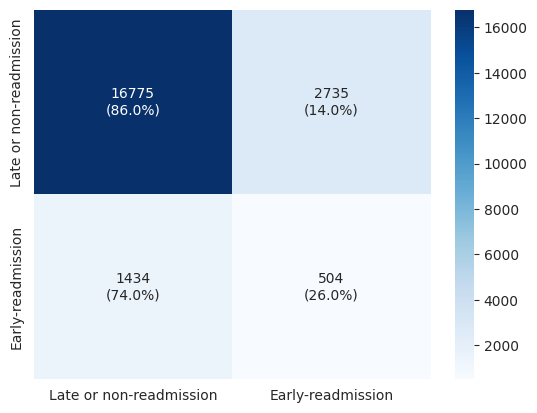

In [281]:
# Visualize confusion matrix with both absolute and percentage values
cm_smote = confusion_matrix(y_test, y_test_pred_smote)
cm_smote_norm = confusion_matrix(y_test, y_test_pred_smote, normalize='true')

annotations_smote = np.array([
    [f"{val}\n({perc:.1%})" for val, perc in zip(row, norm_row)]
    for row, norm_row in zip(cm_smote, cm_smote_norm)
])

sns.heatmap(
    cm_smote,
    annot=annotations_smote,
    cmap='Blues',
    fmt='',
    xticklabels=['Late or non-readmission', 'Early-readmission'],
    yticklabels=['Late or non-readmission', 'Early-readmission']
)

## **5. Optuna Hyper-parameter Tuning | SMOTE + Tomek Links**
Hyper-parameter tuning of the model using Optuna, by oversampling with SMOTE and undersampling with Tomek Links.

### 5.1 Objective & study setup
Preparing the objective function with all hyper-parameters, and creating/loading the Optuna study.

In [282]:
def objective(trial: optuna.Trial) -> float:
    # Hyperparameter search space
    params = {
        "n_estimators": 100,
        "max_depth": trial.suggest_int("max_depth", 14, 40, step=2),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 16, 100, step=2)
    }
    
    # Build pipeline
    pipeline = make_pipeline(
        SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'), random_state=RANDOM_STATE),
        RandomForestClassifier(**params, random_state=RANDOM_STATE)
    )
    
    # Define validation folds
    kf = StratifiedKFold(n_splits=5, shuffle=False)
    
    # Cross validation
    scores = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring=SCORING)

    print("Cross validation scores: {}".format(scores))
    print("Average score: {}".format(scores.mean()))

    return scores.mean()

In [283]:
# Set up study with name and storage
storage = JournalStorage(JournalFileBackend(STUDY_PATH_SMOTE_TOMEK))

study = optuna.create_study(
    direction="maximize",
    study_name=STUDY_NAME,
    storage=storage,
    load_if_exists=True,
    sampler=optuna.samplers.TPESampler(constant_liar=True, seed=RANDOM_STATE),
    pruner=optuna.pruners.SuccessiveHalvingPruner()
)

optuna.logging.set_verbosity(optuna.logging.INFO)

/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/optuna/_experimental.py:31: ExperimentalWarning:

Argument ``constant_liar`` is an experimental feature. The interface can change in the future.

[I 2024-12-31 13:14:50,241] A new study created in Journal with name: Diabetes_130-US


### 5.2 Hyper-parameter tuning
**(CAUTION)** <u>Do not run</u>, unless you already need to find the best parameters. If you already have bound the best model configuration, <u>run the section above</u> _(Objective & study setup)_.

In [284]:
study.optimize(
    objective,
    n_trials=N_TRIALS,
    n_jobs=-1 # Use all available cores
)

[I 2024-12-31 13:15:59,773] Trial 6 finished with value: 0.5396566847828502 and parameters: {'max_depth': 22, 'min_samples_leaf': 94}. Best is trial 6 with value: 0.5396566847828502.


Cross validation scores: [0.53859357 0.54018998 0.54481664 0.54051138 0.53417185]
Average score: 0.5396566847828502


[I 2024-12-31 13:16:00,279] Trial 1 finished with value: 0.5395848390163881 and parameters: {'max_depth': 14, 'min_samples_leaf': 18}. Best is trial 6 with value: 0.5396566847828502.


Cross validation scores: [0.53776521 0.53745348 0.5454495  0.54118492 0.53607109]
Average score: 0.5395848390163881


[I 2024-12-31 13:16:02,257] Trial 3 finished with value: 0.5395547252648037 and parameters: {'max_depth': 14, 'min_samples_leaf': 70}. Best is trial 6 with value: 0.5396566847828502.


Cross validation scores: [0.53798976 0.53869301 0.54716831 0.54128164 0.5326409 ]
Average score: 0.5395547252648037


[I 2024-12-31 13:16:03,752] Trial 2 finished with value: 0.5396020068063762 and parameters: {'max_depth': 22, 'min_samples_leaf': 86}. Best is trial 6 with value: 0.5396566847828502.


Cross validation scores: [0.53500434 0.54759124 0.54825474 0.53755709 0.52960262]
Average score: 0.5396020068063762


[I 2024-12-31 13:16:05,755] Trial 11 finished with value: 0.539255310759476 and parameters: {'max_depth': 28, 'min_samples_leaf': 84}. Best is trial 6 with value: 0.5396566847828502.


Cross validation scores: [0.53590318 0.54754596 0.54474532 0.53784879 0.5302333 ]
Average score: 0.539255310759476


[I 2024-12-31 13:16:06,395] Trial 8 finished with value: 0.5399718210346758 and parameters: {'max_depth': 40, 'min_samples_leaf': 66}. Best is trial 8 with value: 0.5399718210346758.


Cross validation scores: [0.53921393 0.54508755 0.54732186 0.53767903 0.53055673]
Average score: 0.5399718210346758


[I 2024-12-31 13:16:08,110] Trial 10 finished with value: 0.5393680209582963 and parameters: {'max_depth': 32, 'min_samples_leaf': 58}. Best is trial 8 with value: 0.5399718210346758.


Cross validation scores: [0.54026463 0.54394379 0.53959991 0.54180818 0.5312236 ]
Average score: 0.5393680209582963


[I 2024-12-31 13:16:09,917] Trial 4 finished with value: 0.5395801045151118 and parameters: {'max_depth': 34, 'min_samples_leaf': 44}. Best is trial 8 with value: 0.5399718210346758.


Cross validation scores: [0.53867557 0.54284857 0.54376193 0.53881126 0.53380318]
Average score: 0.5395801045151118


[I 2024-12-31 13:16:10,228] Trial 0 finished with value: 0.5366814374231554 and parameters: {'max_depth': 32, 'min_samples_leaf': 32}. Best is trial 8 with value: 0.5399718210346758.
[I 2024-12-31 13:16:10,350] Trial 5 finished with value: 0.5398553389696588 and parameters: {'max_depth': 24, 'min_samples_leaf': 46}. Best is trial 8 with value: 0.5399718210346758.


Cross validation scores: [0.53590606 0.53580758 0.54256907 0.53917892 0.52994555]
Average score: 0.5366814374231554
Cross validation scores: [0.53810335 0.54324135 0.54322337 0.53846617 0.53624245]
Average score: 0.5398553389696588


[I 2024-12-31 13:16:11,289] Trial 9 finished with value: 0.536045830435809 and parameters: {'max_depth': 24, 'min_samples_leaf': 32}. Best is trial 8 with value: 0.5399718210346758.


Cross validation scores: [0.53266171 0.54244481 0.5358141  0.54044092 0.52886761]
Average score: 0.536045830435809


[I 2024-12-31 13:16:12,699] Trial 7 finished with value: 0.5289252659619892 and parameters: {'max_depth': 22, 'min_samples_leaf': 16}. Best is trial 8 with value: 0.5399718210346758.


Cross validation scores: [0.52827933 0.53448283 0.52601074 0.53349938 0.52235406]
Average score: 0.5289252659619892


[I 2024-12-31 13:17:10,133] Trial 12 finished with value: 0.5399819734278825 and parameters: {'max_depth': 14, 'min_samples_leaf': 60}. Best is trial 12 with value: 0.5399819734278825.


Cross validation scores: [0.53791417 0.53997877 0.54445408 0.54464931 0.53291353]
Average score: 0.5399819734278825


[I 2024-12-31 13:17:15,239] Trial 13 finished with value: 0.5354887689750951 and parameters: {'max_depth': 18, 'min_samples_leaf': 18}. Best is trial 12 with value: 0.5399819734278825.


Cross validation scores: [0.53502777 0.54089596 0.53440625 0.53930158 0.52781228]
Average score: 0.5354887689750951


[I 2024-12-31 13:17:16,127] Trial 17 finished with value: 0.5396341549196378 and parameters: {'max_depth': 28, 'min_samples_leaf': 98}. Best is trial 12 with value: 0.5399819734278825.


Cross validation scores: [0.53597321 0.54337308 0.5470313  0.53833343 0.53345976]
Average score: 0.5396341549196378


[I 2024-12-31 13:17:16,491] Trial 15 finished with value: 0.5381458988240793 and parameters: {'max_depth': 22, 'min_samples_leaf': 32}. Best is trial 12 with value: 0.5399819734278825.


Cross validation scores: [0.53856708 0.54061999 0.54165231 0.54052584 0.52936428]
Average score: 0.5381458988240793


[I 2024-12-31 13:17:17,555] Trial 14 finished with value: 0.5348780484904813 and parameters: {'max_depth': 22, 'min_samples_leaf': 24}. Best is trial 12 with value: 0.5399819734278825.


Cross validation scores: [0.53190368 0.53740948 0.53728169 0.53747398 0.53032141]
Average score: 0.5348780484904813


[I 2024-12-31 13:17:18,787] Trial 18 finished with value: 0.5391737252997189 and parameters: {'max_depth': 22, 'min_samples_leaf': 84}. Best is trial 12 with value: 0.5399819734278825.


Cross validation scores: [0.53520695 0.54905003 0.54353943 0.5381039  0.52996832]
Average score: 0.5391737252997189


[I 2024-12-31 13:17:20,997] Trial 19 finished with value: 0.5412829659022156 and parameters: {'max_depth': 16, 'min_samples_leaf': 66}. Best is trial 19 with value: 0.5412829659022156.
[I 2024-12-31 13:17:21,046] Trial 16 finished with value: 0.5356912362293722 and parameters: {'max_depth': 30, 'min_samples_leaf': 28}. Best is trial 19 with value: 0.5412829659022156.


Cross validation scores: [0.53642655 0.54318215 0.54962666 0.53853182 0.53864764]
Average score: 0.5412829659022156
Cross validation scores: [0.53884662 0.53725011 0.53560807 0.53804917 0.52870221]
Average score: 0.5356912362293722


[I 2024-12-31 13:17:23,825] Trial 21 finished with value: 0.5412963050327543 and parameters: {'max_depth': 40, 'min_samples_leaf': 76}. Best is trial 21 with value: 0.5412963050327543.


Cross validation scores: [0.54039332 0.54242178 0.54545419 0.54171597 0.53649626]
Average score: 0.5412963050327543


[I 2024-12-31 13:17:24,409] Trial 20 finished with value: 0.5400336496615497 and parameters: {'max_depth': 20, 'min_samples_leaf': 44}. Best is trial 21 with value: 0.5412963050327543.


Cross validation scores: [0.53876098 0.54053037 0.54337228 0.54451175 0.53299286]
Average score: 0.5400336496615497


[I 2024-12-31 13:17:25,668] Trial 22 finished with value: 0.5378498249641475 and parameters: {'max_depth': 40, 'min_samples_leaf': 48}. Best is trial 21 with value: 0.5412963050327543.


Cross validation scores: [0.53655537 0.5422157  0.54067502 0.53867483 0.53112821]
Average score: 0.5378498249641475


[I 2024-12-31 13:17:26,681] Trial 23 finished with value: 0.5388538415948754 and parameters: {'max_depth': 36, 'min_samples_leaf': 52}. Best is trial 21 with value: 0.5412963050327543.


Cross validation scores: [0.53953243 0.54412477 0.54553345 0.53712944 0.52794911]
Average score: 0.5388538415948754


[I 2024-12-31 13:18:24,827] Trial 24 finished with value: 0.5396082550853356 and parameters: {'max_depth': 36, 'min_samples_leaf': 60}. Best is trial 21 with value: 0.5412963050327543.


Cross validation scores: [0.5353309  0.54547212 0.54390777 0.53878926 0.53454122]
Average score: 0.5396082550853356


[I 2024-12-31 13:18:26,943] Trial 27 finished with value: 0.5397662052054881 and parameters: {'max_depth': 18, 'min_samples_leaf': 78}. Best is trial 21 with value: 0.5412963050327543.


Cross validation scores: [0.53701548 0.54272647 0.5453372  0.53833515 0.53541672]
Average score: 0.5397662052054881


[I 2024-12-31 13:18:28,414] Trial 25 finished with value: 0.5394087974509214 and parameters: {'max_depth': 38, 'min_samples_leaf': 72}. Best is trial 21 with value: 0.5412963050327543.


Cross validation scores: [0.53770448 0.54553684 0.54377423 0.54014099 0.52988745]
Average score: 0.5394087974509214


[I 2024-12-31 13:18:28,758] Trial 26 finished with value: 0.5403967989952545 and parameters: {'max_depth': 26, 'min_samples_leaf': 62}. Best is trial 21 with value: 0.5412963050327543.


Cross validation scores: [0.53909469 0.54314451 0.54412041 0.54130321 0.53432118]
Average score: 0.5403967989952545


[I 2024-12-31 13:18:31,003] Trial 28 finished with value: 0.5394729423272562 and parameters: {'max_depth': 32, 'min_samples_leaf': 54}. Best is trial 21 with value: 0.5412963050327543.


Cross validation scores: [0.53840436 0.54419414 0.54351261 0.53839752 0.53285608]
Average score: 0.5394729423272562


[I 2024-12-31 13:18:31,384] Trial 30 finished with value: 0.5388740702417866 and parameters: {'max_depth': 16, 'min_samples_leaf': 68}. Best is trial 21 with value: 0.5412963050327543.


Cross validation scores: [0.53566154 0.54128822 0.54230706 0.54096042 0.53415311]
Average score: 0.5388740702417866


[I 2024-12-31 13:18:31,730] Trial 31 finished with value: 0.5400009832742123 and parameters: {'max_depth': 14, 'min_samples_leaf': 90}. Best is trial 21 with value: 0.5412963050327543.


Cross validation scores: [0.53453506 0.54149808 0.55105252 0.53991812 0.53300114]
Average score: 0.5400009832742123


[I 2024-12-31 13:18:33,170] Trial 29 finished with value: 0.5396418768063969 and parameters: {'max_depth': 30, 'min_samples_leaf': 38}. Best is trial 21 with value: 0.5412963050327543.


Cross validation scores: [0.54041093 0.54232419 0.54129112 0.54133486 0.53284829]
Average score: 0.5396418768063969


[I 2024-12-31 13:18:35,019] Trial 32 finished with value: 0.5376640230467171 and parameters: {'max_depth': 16, 'min_samples_leaf': 76}. Best is trial 21 with value: 0.5412963050327543.


Cross validation scores: [0.53447931 0.53809701 0.54467201 0.53623957 0.53483222]
Average score: 0.5376640230467171


[I 2024-12-31 13:18:36,787] Trial 33 finished with value: 0.5402069676801327 and parameters: {'max_depth': 18, 'min_samples_leaf': 40}. Best is trial 21 with value: 0.5412963050327543.


Cross validation scores: [0.53726965 0.54300791 0.54484111 0.54199743 0.53391874]
Average score: 0.5402069676801327


[I 2024-12-31 13:18:37,081] Trial 34 finished with value: 0.5395006525258161 and parameters: {'max_depth': 20, 'min_samples_leaf': 78}. Best is trial 21 with value: 0.5412963050327543.


Cross validation scores: [0.53982444 0.54029327 0.5469598  0.53613227 0.53429348]
Average score: 0.5395006525258161


[I 2024-12-31 13:18:38,344] Trial 35 finished with value: 0.5411611796032141 and parameters: {'max_depth': 16, 'min_samples_leaf': 52}. Best is trial 21 with value: 0.5412963050327543.


Cross validation scores: [0.54020496 0.54523402 0.54730753 0.53825456 0.53480483]
Average score: 0.5411611796032141


[I 2024-12-31 13:19:37,569] Trial 36 finished with value: 0.5388325908195903 and parameters: {'max_depth': 20, 'min_samples_leaf': 64}. Best is trial 21 with value: 0.5412963050327543.


Cross validation scores: [0.53760256 0.53686503 0.54749865 0.53999876 0.53219796]
Average score: 0.5388325908195903


[I 2024-12-31 13:19:38,461] Trial 37 finished with value: 0.5388749490337181 and parameters: {'max_depth': 26, 'min_samples_leaf': 72}. Best is trial 21 with value: 0.5412963050327543.


Cross validation scores: [0.53558131 0.54550452 0.54228871 0.54138806 0.52961214]
Average score: 0.5388749490337181


[I 2024-12-31 13:19:40,455] Trial 39 finished with value: 0.5389883223217691 and parameters: {'max_depth': 26, 'min_samples_leaf': 64}. Best is trial 21 with value: 0.5412963050327543.


Cross validation scores: [0.53540034 0.54470638 0.54351316 0.53857556 0.53274618]
Average score: 0.5389883223217691


[I 2024-12-31 13:19:41,612] Trial 38 finished with value: 0.5389492483947002 and parameters: {'max_depth': 20, 'min_samples_leaf': 42}. Best is trial 21 with value: 0.5412963050327543.
[I 2024-12-31 13:19:41,615] Trial 41 finished with value: 0.5384821411076974 and parameters: {'max_depth': 24, 'min_samples_leaf': 92}. Best is trial 21 with value: 0.5412963050327543.


Cross validation scores: [0.53431078 0.54228298 0.54614461 0.53876057 0.5332473 ]
Average score: 0.5389492483947002
Cross validation scores: [0.5349591  0.5427014  0.54517928 0.53620077 0.53337016]
Average score: 0.5384821411076974


[I 2024-12-31 13:19:43,832] Trial 40 finished with value: 0.5393206348977733 and parameters: {'max_depth': 34, 'min_samples_leaf': 82}. Best is trial 21 with value: 0.5412963050327543.


Cross validation scores: [0.53709263 0.54450681 0.54755169 0.53503703 0.53241502]
Average score: 0.5393206348977733


[I 2024-12-31 13:19:45,903] Trial 42 finished with value: 0.541408056755967 and parameters: {'max_depth': 24, 'min_samples_leaf': 56}. Best is trial 42 with value: 0.541408056755967.


Cross validation scores: [0.53974701 0.54302497 0.5472117  0.5441755  0.53288111]
Average score: 0.541408056755967


[I 2024-12-31 13:19:47,532] Trial 43 finished with value: 0.539393965726463 and parameters: {'max_depth': 30, 'min_samples_leaf': 46}. Best is trial 42 with value: 0.541408056755967.
[I 2024-12-31 13:19:47,573] Trial 46 finished with value: 0.5398439177492852 and parameters: {'max_depth': 14, 'min_samples_leaf': 64}. Best is trial 42 with value: 0.541408056755967.
[I 2024-12-31 13:19:47,610] Trial 44 finished with value: 0.5404804613947639 and parameters: {'max_depth': 26, 'min_samples_leaf': 70}. Best is trial 42 with value: 0.541408056755967.


Cross validation scores: [0.54030531 0.5388954  0.5457846  0.53953915 0.53244537]
Average score: 0.539393965726463
Cross validation scores: [0.53339158 0.54275308 0.54704945 0.54064151 0.53538398]
Average score: 0.5398439177492852
Cross validation scores: [0.53935318 0.54408547 0.54541061 0.53848482 0.53506824]
Average score: 0.5404804613947639


[I 2024-12-31 13:19:50,209] Trial 47 finished with value: 0.539292671520142 and parameters: {'max_depth': 16, 'min_samples_leaf': 50}. Best is trial 42 with value: 0.541408056755967.


Cross validation scores: [0.53571319 0.53993839 0.54192256 0.53970779 0.53918143]
Average score: 0.539292671520142


[I 2024-12-31 13:19:50,515] Trial 45 finished with value: 0.5400744908029551 and parameters: {'max_depth': 18, 'min_samples_leaf': 38}. Best is trial 42 with value: 0.541408056755967.


Cross validation scores: [0.53864432 0.54060956 0.54406836 0.54076879 0.53628143]
Average score: 0.5400744908029551


[I 2024-12-31 13:20:49,417] Trial 49 finished with value: 0.5396669298201655 and parameters: {'max_depth': 16, 'min_samples_leaf': 74}. Best is trial 42 with value: 0.541408056755967.


Cross validation scores: [0.53546398 0.54216941 0.5467554  0.54131533 0.53263053]
Average score: 0.5396669298201655


[I 2024-12-31 13:20:51,973] Trial 48 finished with value: 0.5396082550853356 and parameters: {'max_depth': 38, 'min_samples_leaf': 60}. Best is trial 42 with value: 0.541408056755967.


Cross validation scores: [0.5353309  0.54547212 0.54390777 0.53878926 0.53454122]
Average score: 0.5396082550853356


[I 2024-12-31 13:20:52,344] Trial 52 finished with value: 0.5407259422578898 and parameters: {'max_depth': 14, 'min_samples_leaf': 50}. Best is trial 42 with value: 0.541408056755967.


Cross validation scores: [0.53682097 0.54093912 0.55109434 0.53971627 0.53505901]
Average score: 0.5407259422578898


[I 2024-12-31 13:20:53,831] Trial 50 finished with value: 0.5401978117639584 and parameters: {'max_depth': 32, 'min_samples_leaf': 56}. Best is trial 42 with value: 0.541408056755967.


Cross validation scores: [0.53649618 0.54545826 0.5459151  0.54191279 0.53120672]
Average score: 0.5401978117639584


[I 2024-12-31 13:20:54,179] Trial 53 finished with value: 0.5388740702417866 and parameters: {'max_depth': 16, 'min_samples_leaf': 68}. Best is trial 42 with value: 0.541408056755967.


Cross validation scores: [0.53566154 0.54128822 0.54230706 0.54096042 0.53415311]
Average score: 0.5388740702417866


[I 2024-12-31 13:20:55,347] Trial 51 finished with value: 0.5402069676801327 and parameters: {'max_depth': 18, 'min_samples_leaf': 40}. Best is trial 42 with value: 0.541408056755967.


Cross validation scores: [0.53726965 0.54300791 0.54484111 0.54199743 0.53391874]
Average score: 0.5402069676801327


[I 2024-12-31 13:20:58,053] Trial 54 finished with value: 0.5404971252158138 and parameters: {'max_depth': 24, 'min_samples_leaf': 58}. Best is trial 42 with value: 0.541408056755967.


Cross validation scores: [0.5411703  0.54670268 0.54236138 0.54221365 0.53003761]
Average score: 0.5404971252158138


[I 2024-12-31 13:20:59,957] Trial 58 finished with value: 0.5401905234089162 and parameters: {'max_depth': 34, 'min_samples_leaf': 100}. Best is trial 42 with value: 0.541408056755967.


Cross validation scores: [0.53591267 0.54527788 0.54547384 0.54204779 0.53224043]
Average score: 0.5401905234089162


[I 2024-12-31 13:21:00,391] Trial 57 finished with value: 0.5399952279469564 and parameters: {'max_depth': 24, 'min_samples_leaf': 82}. Best is trial 42 with value: 0.541408056755967.
[I 2024-12-31 13:21:00,489] Trial 55 finished with value: 0.5403678396038132 and parameters: {'max_depth': 28, 'min_samples_leaf': 54}. Best is trial 42 with value: 0.541408056755967.


Cross validation scores: [0.53851723 0.54442063 0.54660415 0.53697416 0.53345997]
Average score: 0.5399952279469564
Cross validation scores: [0.54047456 0.5461748  0.54380854 0.53965317 0.53172813]
Average score: 0.5403678396038132


[I 2024-12-31 13:21:00,962] Trial 56 finished with value: 0.540658979040306 and parameters: {'max_depth': 28, 'min_samples_leaf': 70}. Best is trial 42 with value: 0.541408056755967.


Cross validation scores: [0.53895383 0.54653062 0.54320383 0.54012354 0.53448307]
Average score: 0.540658979040306


[I 2024-12-31 13:21:02,799] Trial 59 finished with value: 0.539927272934664 and parameters: {'max_depth': 26, 'min_samples_leaf': 68}. Best is trial 42 with value: 0.541408056755967.


Cross validation scores: [0.53708355 0.54419092 0.54722261 0.53740507 0.53373423]
Average score: 0.539927272934664


[I 2024-12-31 13:21:59,767] Trial 60 finished with value: 0.5396020068063762 and parameters: {'max_depth': 22, 'min_samples_leaf': 86}. Best is trial 42 with value: 0.541408056755967.


Cross validation scores: [0.53500434 0.54759124 0.54825474 0.53755709 0.52960262]
Average score: 0.5396020068063762


[I 2024-12-31 13:22:02,695] Trial 62 finished with value: 0.5410478907304297 and parameters: {'max_depth': 14, 'min_samples_leaf': 52}. Best is trial 42 with value: 0.541408056755967.


Cross validation scores: [0.53700458 0.54009564 0.55068347 0.54075526 0.5367005 ]
Average score: 0.5410478907304297


[I 2024-12-31 13:22:04,971] Trial 63 finished with value: 0.54129552851259 and parameters: {'max_depth': 14, 'min_samples_leaf': 48}. Best is trial 42 with value: 0.541408056755967.
[I 2024-12-31 13:22:04,989] Trial 61 finished with value: 0.5398997872910873 and parameters: {'max_depth': 30, 'min_samples_leaf': 78}. Best is trial 42 with value: 0.541408056755967.


Cross validation scores: [0.53995073 0.54060654 0.54779124 0.53881265 0.53931648]
Average score: 0.54129552851259
Cross validation scores: [0.53833553 0.54440935 0.54744825 0.53533193 0.53397387]
Average score: 0.5398997872910873


[I 2024-12-31 13:22:06,071] Trial 65 finished with value: 0.5417831726896439 and parameters: {'max_depth': 14, 'min_samples_leaf': 62}. Best is trial 65 with value: 0.5417831726896439.
[I 2024-12-31 13:22:06,209] Trial 64 finished with value: 0.5410374189572611 and parameters: {'max_depth': 16, 'min_samples_leaf': 56}. Best is trial 65 with value: 0.5417831726896439.


Cross validation scores: [0.53503975 0.54332882 0.55190793 0.54255204 0.53608732]
Average score: 0.5417831726896439
Cross validation scores: [0.54019343 0.54014447 0.54838929 0.54044842 0.53601149]
Average score: 0.5410374189572611


[I 2024-12-31 13:22:10,487] Trial 66 finished with value: 0.5404971252158138 and parameters: {'max_depth': 24, 'min_samples_leaf': 58}. Best is trial 65 with value: 0.5417831726896439.


Cross validation scores: [0.5411703  0.54670268 0.54236138 0.54221365 0.53003761]
Average score: 0.5404971252158138


[I 2024-12-31 13:22:12,487] Trial 67 finished with value: 0.5385505641339009 and parameters: {'max_depth': 22, 'min_samples_leaf': 50}. Best is trial 65 with value: 0.5417831726896439.


Cross validation scores: [0.53719306 0.54083663 0.54169463 0.53915387 0.53387462]
Average score: 0.5385505641339009


[I 2024-12-31 13:22:13,491] Trial 68 finished with value: 0.5386600212439403 and parameters: {'max_depth': 18, 'min_samples_leaf': 58}. Best is trial 65 with value: 0.5417831726896439.
[I 2024-12-31 13:22:13,627] Trial 69 finished with value: 0.5393332857988267 and parameters: {'max_depth': 20, 'min_samples_leaf': 46}. Best is trial 65 with value: 0.5417831726896439.


Cross validation scores: [0.5344151  0.54376154 0.54354048 0.53921217 0.53237081]
Average score: 0.5386600212439403
Cross validation scores: [0.53686184 0.54271578 0.53950485 0.54253634 0.53504762]
Average score: 0.5393332857988267


[I 2024-12-31 13:22:15,159] Trial 71 finished with value: 0.539232653316288 and parameters: {'max_depth': 36, 'min_samples_leaf': 74}. Best is trial 65 with value: 0.5417831726896439.


Cross validation scores: [0.53329163 0.54398114 0.54796829 0.53774754 0.53317467]
Average score: 0.539232653316288


[I 2024-12-31 13:22:16,684] Trial 70 finished with value: 0.5372188880301202 and parameters: {'max_depth': 40, 'min_samples_leaf': 32}. Best is trial 65 with value: 0.5417831726896439.


Cross validation scores: [0.53961602 0.53617181 0.54280885 0.53924203 0.52825572]
Average score: 0.5372188880301202


[I 2024-12-31 13:23:11,905] Trial 72 finished with value: 0.5403678396038132 and parameters: {'max_depth': 28, 'min_samples_leaf': 54}. Best is trial 65 with value: 0.5417831726896439.


Cross validation scores: [0.54047456 0.5461748  0.54380854 0.53965317 0.53172813]
Average score: 0.5403678396038132


[I 2024-12-31 13:23:14,857] Trial 73 finished with value: 0.5410478907304297 and parameters: {'max_depth': 14, 'min_samples_leaf': 52}. Best is trial 65 with value: 0.5417831726896439.


Cross validation scores: [0.53700458 0.54009564 0.55068347 0.54075526 0.5367005 ]
Average score: 0.5410478907304297


[I 2024-12-31 13:23:16,255] Trial 75 finished with value: 0.54129552851259 and parameters: {'max_depth': 14, 'min_samples_leaf': 48}. Best is trial 65 with value: 0.5417831726896439.


Cross validation scores: [0.53995073 0.54060654 0.54779124 0.53881265 0.53931648]
Average score: 0.54129552851259


[I 2024-12-31 13:23:17,484] Trial 74 finished with value: 0.54129552851259 and parameters: {'max_depth': 14, 'min_samples_leaf': 48}. Best is trial 65 with value: 0.5417831726896439.


Cross validation scores: [0.53995073 0.54060654 0.54779124 0.53881265 0.53931648]
Average score: 0.54129552851259


[I 2024-12-31 13:23:18,253] Trial 77 finished with value: 0.5399819734278825 and parameters: {'max_depth': 14, 'min_samples_leaf': 60}. Best is trial 65 with value: 0.5417831726896439.


Cross validation scores: [0.53791417 0.53997877 0.54445408 0.54464931 0.53291353]
Average score: 0.5399819734278825


[I 2024-12-31 13:23:18,588] Trial 76 finished with value: 0.5412829659022156 and parameters: {'max_depth': 16, 'min_samples_leaf': 66}. Best is trial 65 with value: 0.5417831726896439.


Cross validation scores: [0.53642655 0.54318215 0.54962666 0.53853182 0.53864764]
Average score: 0.5412829659022156


[I 2024-12-31 13:23:22,016] Trial 79 finished with value: 0.5399055416613305 and parameters: {'max_depth': 14, 'min_samples_leaf': 44}. Best is trial 65 with value: 0.5417831726896439.
[I 2024-12-31 13:23:22,114] Trial 78 finished with value: 0.539725661025279 and parameters: {'max_depth': 16, 'min_samples_leaf': 62}. Best is trial 65 with value: 0.5417831726896439.


Cross validation scores: [0.53878249 0.53886813 0.5444134  0.54017862 0.53728508]
Average score: 0.5399055416613305
Cross validation scores: [0.53436164 0.54196462 0.5438375  0.5394951  0.53896944]
Average score: 0.539725661025279


[I 2024-12-31 13:23:24,298] Trial 81 finished with value: 0.539725661025279 and parameters: {'max_depth': 16, 'min_samples_leaf': 62}. Best is trial 65 with value: 0.5417831726896439.


Cross validation scores: [0.53436164 0.54196462 0.5438375  0.5394951  0.53896944]
Average score: 0.539725661025279


[I 2024-12-31 13:23:27,161] Trial 80 finished with value: 0.5394467203406857 and parameters: {'max_depth': 18, 'min_samples_leaf': 52}. Best is trial 65 with value: 0.5417831726896439.


Cross validation scores: [0.53343416 0.54476092 0.54472259 0.54185856 0.53245738]
Average score: 0.5394467203406857


[I 2024-12-31 13:23:27,488] Trial 82 finished with value: 0.5410374189572611 and parameters: {'max_depth': 16, 'min_samples_leaf': 56}. Best is trial 65 with value: 0.5417831726896439.


Cross validation scores: [0.54019343 0.54014447 0.54838929 0.54044842 0.53601149]
Average score: 0.5410374189572611


[I 2024-12-31 13:23:29,256] Trial 83 finished with value: 0.5399061317162545 and parameters: {'max_depth': 14, 'min_samples_leaf': 54}. Best is trial 65 with value: 0.5417831726896439.


Cross validation scores: [0.53999876 0.53919241 0.54308257 0.54247425 0.53478267]
Average score: 0.5399061317162545


[I 2024-12-31 13:24:23,261] Trial 84 finished with value: 0.5410374189572611 and parameters: {'max_depth': 16, 'min_samples_leaf': 56}. Best is trial 65 with value: 0.5417831726896439.


Cross validation scores: [0.54019343 0.54014447 0.54838929 0.54044842 0.53601149]
Average score: 0.5410374189572611


[I 2024-12-31 13:24:26,705] Trial 85 finished with value: 0.5410478907304297 and parameters: {'max_depth': 14, 'min_samples_leaf': 52}. Best is trial 65 with value: 0.5417831726896439.


Cross validation scores: [0.53700458 0.54009564 0.55068347 0.54075526 0.5367005 ]
Average score: 0.5410478907304297


[I 2024-12-31 13:24:29,362] Trial 86 finished with value: 0.5388039571640166 and parameters: {'max_depth': 14, 'min_samples_leaf': 34}. Best is trial 65 with value: 0.5417831726896439.


Cross validation scores: [0.53456283 0.53870624 0.54640637 0.53911062 0.53523372]
Average score: 0.5388039571640166


[I 2024-12-31 13:24:30,895] Trial 88 finished with value: 0.5402717230193831 and parameters: {'max_depth': 14, 'min_samples_leaf': 46}. Best is trial 65 with value: 0.5417831726896439.


Cross validation scores: [0.54002174 0.5387291  0.54796921 0.53925449 0.53538408]
Average score: 0.5402717230193831


[I 2024-12-31 13:24:31,296] Trial 89 finished with value: 0.5412829659022156 and parameters: {'max_depth': 16, 'min_samples_leaf': 66}. Best is trial 65 with value: 0.5417831726896439.


Cross validation scores: [0.53642655 0.54318215 0.54962666 0.53853182 0.53864764]
Average score: 0.5412829659022156


[I 2024-12-31 13:24:31,511] Trial 87 finished with value: 0.537481262177186 and parameters: {'max_depth': 18, 'min_samples_leaf': 48}. Best is trial 65 with value: 0.5417831726896439.


Cross validation scores: [0.53355323 0.5404409  0.54064315 0.54127033 0.5314987 ]
Average score: 0.537481262177186


[I 2024-12-31 13:24:33,093] Trial 91 finished with value: 0.5413214503978103 and parameters: {'max_depth': 14, 'min_samples_leaf': 42}. Best is trial 65 with value: 0.5417831726896439.


Cross validation scores: [0.53403123 0.54392611 0.54924984 0.54156651 0.53783356]
Average score: 0.5413214503978103


[I 2024-12-31 13:24:33,406] Trial 90 finished with value: 0.5392797325558667 and parameters: {'max_depth': 18, 'min_samples_leaf': 66}. Best is trial 65 with value: 0.5417831726896439.


Cross validation scores: [0.53747298 0.54096251 0.54399775 0.53715492 0.53681051]
Average score: 0.5392797325558667


[I 2024-12-31 13:24:34,629] Trial 92 finished with value: 0.5396022228014539 and parameters: {'max_depth': 16, 'min_samples_leaf': 48}. Best is trial 65 with value: 0.5417831726896439.


Cross validation scores: [0.53863687 0.53726495 0.54536509 0.53890852 0.53783569]
Average score: 0.5396022228014539


[I 2024-12-31 13:24:35,524] Trial 93 finished with value: 0.5393981319535333 and parameters: {'max_depth': 14, 'min_samples_leaf': 72}. Best is trial 65 with value: 0.5417831726896439.


Cross validation scores: [0.53100435 0.54040142 0.5483272  0.54041406 0.53684362]
Average score: 0.5393981319535333


[I 2024-12-31 13:24:36,830] Trial 94 finished with value: 0.5408933795544926 and parameters: {'max_depth': 16, 'min_samples_leaf': 64}. Best is trial 65 with value: 0.5417831726896439.


Cross validation scores: [0.53925918 0.54117404 0.54977685 0.54079044 0.53346639]
Average score: 0.5408933795544926


[I 2024-12-31 13:24:39,993] Trial 95 finished with value: 0.5398765398011385 and parameters: {'max_depth': 38, 'min_samples_leaf': 44}. Best is trial 65 with value: 0.5417831726896439.


Cross validation scores: [0.53867557 0.54332159 0.54376193 0.53961095 0.53401265]
Average score: 0.5398765398011385


[I 2024-12-31 13:25:03,827] Trial 96 finished with value: 0.5396208856164226 and parameters: {'max_depth': 20, 'min_samples_leaf': 60}. Best is trial 65 with value: 0.5417831726896439.


Cross validation scores: [0.53488684 0.54507741 0.54346523 0.54063715 0.5340378 ]
Average score: 0.5396208856164226


[I 2024-12-31 13:25:07,006] Trial 98 finished with value: 0.54129552851259 and parameters: {'max_depth': 14, 'min_samples_leaf': 48}. Best is trial 65 with value: 0.5417831726896439.


Cross validation scores: [0.53995073 0.54060654 0.54779124 0.53881265 0.53931648]
Average score: 0.54129552851259


[I 2024-12-31 13:25:07,515] Trial 97 finished with value: 0.5367875363563489 and parameters: {'max_depth': 18, 'min_samples_leaf': 36}. Best is trial 65 with value: 0.5417831726896439.
[I 2024-12-31 13:25:07,637] Trial 99 finished with value: 0.5412829659022156 and parameters: {'max_depth': 16, 'min_samples_leaf': 66}. Best is trial 65 with value: 0.5417831726896439.


Cross validation scores: [0.53516543 0.53791097 0.54122388 0.54140758 0.52822982]
Average score: 0.5367875363563489
Cross validation scores: [0.53642655 0.54318215 0.54962666 0.53853182 0.53864764]
Average score: 0.5412829659022156


In [285]:
print('Best Trial: {}'.format(study.best_trial.number))
print('Best Parameters: {}'.format(study.best_params))
print('Best Value: {}'.format(study.best_value))

Best Trial: 65
Best Parameters: {'max_depth': 14, 'min_samples_leaf': 62}
Best Value: 0.5417831726896439


### 5.3 Optuna Visualizations
Visualizing hyper-parameter tuning results obtained by running Optuna.

In [286]:
optuna.visualization.plot_optimization_history(study)

In [287]:
optuna.visualization.plot_slice(study)

In [288]:
optuna.visualization.plot_param_importances(study)

In [289]:
optuna.visualization.plot_parallel_coordinate(study)

In [290]:
optuna.visualization.plot_contour(study)

In [291]:
optuna.visualization.plot_timeline(study)

### 5.4 Fitting Best Model
Fitting the final model using the best hyper-parameters found by Optuna.

In [292]:
# Fit best model on the training set
best_params = study.best_params

pipeline_smotetomek = make_pipeline(
    SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'), random_state=RANDOM_STATE),
    RandomForestClassifier(**best_params, random_state=RANDOM_STATE)
)

pipeline_smotetomek.fit(X_train, y_train)

Pipeline(steps=[('smotetomek',
                 SMOTETomek(random_state=38,
                            tomek=TomekLinks(sampling_strategy='majority'))),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=14, min_samples_leaf=62,
                                        random_state=38))])

In [293]:
# Predictions
y_train_pred_smotetomek = pipeline_smotetomek.predict(X_train)
y_test_pred_smotetomek = pipeline_smotetomek.predict(X_test)

In [294]:
ac_train_smotetomek = accuracy_score(y_train, y_train_pred_smotetomek)
ac_test_smotetomek = accuracy_score(y_test, y_test_pred_smotetomek)

print('Train accuracy: ', ac_train_smotetomek)
print('Test accuracy: ', ac_test_smotetomek)

Train accuracy:  0.8012388850034968
Test accuracy:  0.7893976128310332


In [295]:
# Visualize precision, recall, F1-score
print(classification_report(
    y_test, y_test_pred_smotetomek,
    target_names=['Late or non-readmission', 'Early-readmission']
))

                         precision    recall  f1-score   support

Late or non-readmission       0.92      0.84      0.88     19510
      Early-readmission       0.15      0.29      0.20      1938

               accuracy                           0.79     21448
              macro avg       0.54      0.56      0.54     21448
           weighted avg       0.85      0.79      0.82     21448



In [296]:
# Compute precision, recall, F1-score, ROC-AUC-score, and accuracy
recall_smotetomek = recall_score(y_test, y_test_pred_smotetomek, average='macro')
precision_smotetomek = precision_score(y_test, y_test_pred_smotetomek, average='macro')
f1_smotetomek = f1_score(y_test, y_test_pred_smotetomek, average='macro')
roc_auc_smotetomek = roc_auc_score(y_test, y_test_pred_smotetomek, average='macro')
accuracy_smotetomek = accuracy_score(y_test, y_test_pred_smotetomek)

<Axes: >

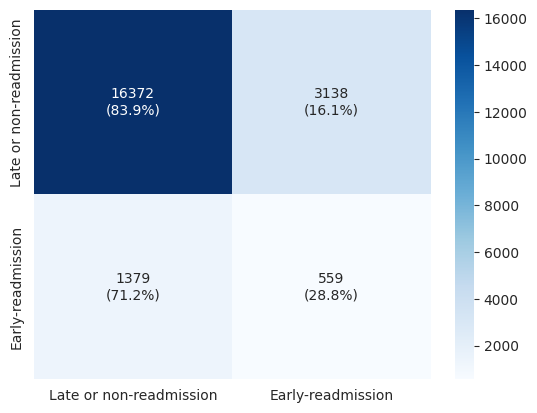

In [297]:
# Visualize confusion matrix with both absolute and percentage values
cm_smotetomek = confusion_matrix(y_test, y_test_pred_smotetomek)
cm_smotetomek_norm = confusion_matrix(y_test, y_test_pred_smotetomek, normalize='true')

annotations_smotetomek = np.array([
    [f"{val}\n({perc:.1%})" for val, perc in zip(row, norm_row)]
    for row, norm_row in zip(cm_smotetomek, cm_smotetomek_norm)
])

sns.heatmap(
    cm_smotetomek,
    annot=annotations_smotetomek,
    cmap='Blues',
    fmt='',
    xticklabels=['Late or non-readmission', 'Early-readmission'],
    yticklabels=['Late or non-readmission', 'Early-readmission']
)

## **6. Results Combined**
Visualizing all results obtained by different sampling methods, on the best respective models.

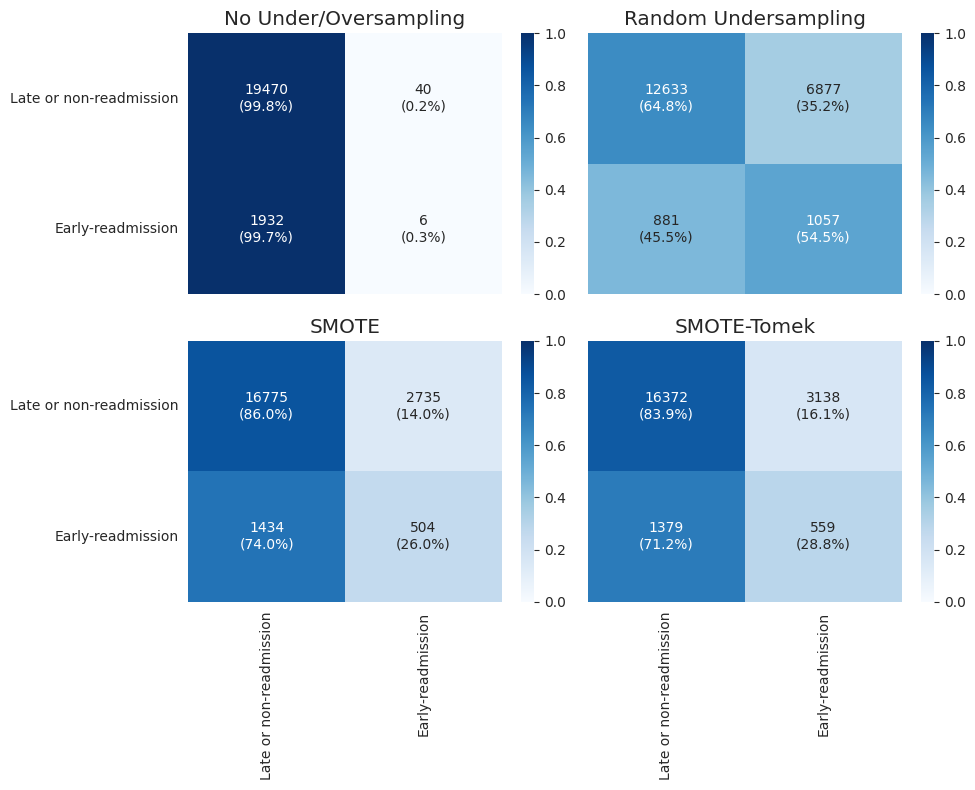

In [298]:
# Combine all confusion matrices into a single plot
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
cm_list = [cm_none_norm, cm_rus_norm, cm_smote_norm, cm_smotetomek_norm]
annotations = [annotations_none, annotations_rus, annotations_smote, annotations_smotetomek]
labels = ['No Under/Oversampling', 'Random Undersampling', 'SMOTE', 'SMOTE-Tomek']

# Define tick labels
xticklabels = ['Late or non-readmission', 'Early-readmission']
yticklabels = ['Late or non-readmission', 'Early-readmission']

for i, cm in enumerate(cm_list):
    ax=axs[i//2, i%2]
    sns.heatmap(
        cm,
        annot=annotations[i],
        cmap='Blues',
        fmt='',
        vmin=0, vmax=1,
        ax=axs[i//2, i%2],
        xticklabels=['Late or non-readmission', 'Early-readmission'],
        yticklabels=['Late or non-readmission', 'Early-readmission']
    )
    ax.set_title(labels[i])
    
    # Hide x-tick labels for the top row
    if i < 2:
        ax.set_xticklabels([])
    # Hide y-tick labels for the right column
    if i % 2 == 1:
        ax.set_yticklabels([])

plt.tight_layout()
plt.show()

Visualizing the scores for each method.

In [299]:
# Combine all metrics into a single DataFrame
data = {
    'Recall': [recall_none, recall_rus, recall_smote, recall_smotetomek],
    'Precision': [precision_none, precision_rus, precision_smote, precision_smotetomek],
    'F1-score': [f1_none, f1_rus, f1_smote, f1_smotetomek],
    'ROC-AUC': [roc_auc_none, roc_auc_rus, roc_auc_smote, roc_auc_smotetomek],
    'Accuracy': [accuracy_none, accuracy_rus, accuracy_smote, accuracy_smotetomek]
}

metrics_df = pd.DataFrame(data, index=labels)
metrics_df

,Recall,Precision,F1-score,ROC-AUC,Accuracy
No Under/Oversampling,0.500523,0.520081,0.478924,0.500523,0.908057
Random Undersampling,0.596461,0.534016,0.489610,0.596461,0.638288
SMOTE,0.559939,0.538426,0.542090,0.559939,0.805623
SMOTE-Tomek,0.563801,0.536759,0.538588,0.563801,0.789398


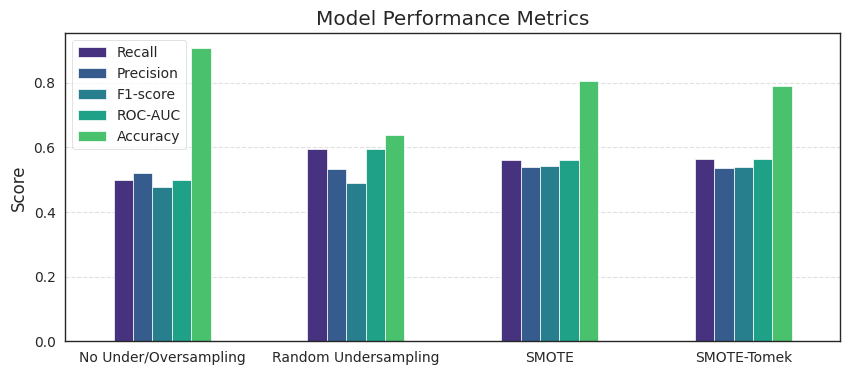

In [300]:
# Visualize all metrics in a bar plot, by coloring each method differently, using SeaBorn barplot and adding grids
sns.set_palette('viridis')
metrics_df.plot(kind='bar', figsize=(10, 4))
plt.title('Model Performance Metrics')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()